# Task 3: Classification

The aim of this notebook is to perform a **predictive analysis** in order to classify our customers in three categories (high-spending, low-spending and medium-spending) on the basis of their shopping behaviour.

We will run, compare and discuss the performance of **10 different models**:

**Distance based classifiers**
- K-Nearest Neighbors
- Radius-Neighbors

**Naive Bayes classifiers**
- Gaussian Naive Bayes
- Multinomial Naive Bayes

**Support Vector Machine**
- Support Vector Classification

**Neural classifiers**
- Feed-forward Neural Network
- Multi-layer Perceptron

**Tree-based classifiers**
- Decision tree

**Ensemble Method**
- Random forest
- Voting classifier

At the end of this notebook, we propose an alternative classification having the label based on the clustering result of with DBSCAN.
In fact, given that this algorithm had already identified clusters of clients grouped according to their shopping behavior, we believe that it may be interesting to present this second analysis (in addition to the first one based on the Savg attribute) and show a comparison between the two approaches.
This second analysis will be performed on all the ten proposed classifiers.

### Import basic libraries

In [32]:
import statistics 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

### Import dataset

In [33]:
cs = pd.read_csv('dataset/customers_num.csv', index_col=0) # modified: loaded the nwe updated dataset (NOT in "dataset" folder)
cs_cat =  pd.read_csv('dataset/customers_cat.csv', index_col=0)

In [34]:
cs_corr_columns = ['Iavg', 'Ew', 'Em', 'Ir', 'Sref', 'SWmax', 'SWavg', 'SMmax', 'SMavg']
cs.drop(cs_corr_columns, axis=1, inplace=True)

KeyError: "['Iavg' 'Ew' 'Em' 'Ir' 'Sref' 'SWmax' 'SWavg' 'SMmax' 'SMavg'] not found in axis"

In [55]:
cs['Country'] = cs_cat['Country']
cs['Fav_weekday'] = cs_cat['Fav_weekday']
cs['Fav_month'] = cs_cat['Fav_month']

In [56]:
cs_num_columns = ['I', 'Iu', 'Imax', 'Ep', 'Eb', 'Stot', 'Smax', 'NSess']

### Transform categorical features into numerical ones

In [57]:
#function to discretize the variables
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [58]:
#discretize the categorical variables
variables = ['Country', 'Fav_weekday', 'Fav_month']
cs = discretize_data(cs, variables)

In [59]:
#drop the categorical variables since we don't need them anymore 
cs.drop(columns=['Country', 'Fav_weekday', 'Fav_month'], axis=1,inplace=True)

In [60]:
#result
cs.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3646 entries, 13047.0 to 12713.0
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   I                3646 non-null   int64  
 1   Iu               3646 non-null   int64  
 2   Imax             3646 non-null   int64  
 3   Ep               3646 non-null   float64
 4   Eb               3646 non-null   float64
 5   Stot             3646 non-null   float64
 6   Smax             3646 non-null   float64
 7   Savg             3646 non-null   float64
 8   NSess            3646 non-null   int64  
 9   Country_num      3646 non-null   int32  
 10  Fav_weekday_num  3646 non-null   int32  
 11  Fav_month_num    3646 non-null   int32  
dtypes: float64(5), int32(3), int64(4)
memory usage: 327.6 KB


### Compute labels

Before proceeding with the execution of several classification algorithms, it is necessary to define the label on the basis of which setting up the **supervised learning** approach.

The indicator we choose to derive the label (i.e. the class: high, medium and low spending) is *Savg*. Our choice falls on this attribute as it is the most representative of the customers' shopping profile: in fact it is calculated on the basis of [...] and takes into account [...].

**How to define the three classes:**

We identified two different ways in which define the three classes:
- **Using percentiles:**
- If Savg < 25% $\rightarrow $ low-spending customer
- If Savg > 75% $\rightarrow $ high-spending customer
- If 25% < Savg < 75% $\rightarrow $ medium-spending customer
- **Using quantiles:** 
- If Savg < 0.33 $\rightarrow $ low-spending customer
- If Savg > 0.66 $\rightarrow $ high-spending customer
- If 0.33 < Savg < 0.66 $\rightarrow $ medium-spending customer

Since we consider the two choices to be equal (i.e. not affecting the result of the analysis), we just choose one.

In [61]:
# label tipo1
quantile_a = cs.Savg.quantile(0.33)
quantile_b = cs.Savg.quantile(0.66)

In [62]:
# label tipo2
#quantile_a = cs.Savg.quantile(0.25)
#quantile_b = cs.Savg.quantile(0.75)

In [63]:
labels = []
for customer, Savg in cs.Savg.items():
    if Savg < quantile_a:
        labels.append(0)
    elif Savg > quantile_b:
        labels.append(2)
    else:
        labels.append(1)

In [64]:
cs.drop(columns=['Savg'], inplace=True)

In [65]:
class_names = ['low-spending', 'medium-spending', 'high-spending']

#### Population of the classes

In [66]:
classes = pd.DataFrame()
classes['labels'] = labels
classes.labels.value_counts()

2    1240
1    1203
0    1203
Name: labels, dtype: int64

The population is **almost equally distributed** among all the three labels. 
The support will therefore be, more or less, the same for all three classes.
This will allow us to avoid using class weights.

### Preparing the training set and test set

In [67]:
from sklearn.model_selection import train_test_split
train_set, test_set, train_label, test_label = train_test_split(cs, labels, stratify=labels, test_size=0.30)

### Aiding the implementation and evaluation of the classifiers with utility functions

In [68]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

#### Add labels on top of bar from bar plots

In [69]:
def autolabel(rects, i = None, j = None):
    if (i != None) and (j!=None): 
        target = axs[i][j]
    elif i != None:
        target = axs[i]
    else:
        target = axs    
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        target.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

#### Display correlations among the attributes

In [70]:
def display_corr(df, corr_threshold = 0.8):
    print('Correlations')
    print("Att. A\tAtt. B\tCorr(A,B)")
    for i in range(0, len(df.columns)):
        for j in range(i+1, len(df.columns)):
            corr = df[df.columns[i]].corr(df[df.columns[j]])
            if  corr > corr_threshold:
                print(df.columns[i] + "\t" + df.columns[j] + "\t" + '{:.4f}'.format(corr))

#### Plot the whole array of scatter plots

In [71]:
def corr_plot(label, label_source):
    nrows, ncols = 5, 6
    index = 0
    f, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(50,30))
    for i in range(len(cs_num_columns)):
        for j in range(i+1,len(cs_num_columns)):
            axs[int(index/ncols)][index%ncols].scatter(test_set.iloc[:, i].values, test_set.iloc[:, j].values, c=label, s=25, cmap='cividis')
            axs[int(index/ncols)][index%ncols].set_title('Correlation of ' + cs.columns[i] + ' and ' + cs.columns[j], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
            axs[int(index/ncols)][index%ncols].set_xlabel(cs.columns[i], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
            axs[int(index/ncols)][index%ncols].set_ylabel(cs.columns[j], fontdict={'fontsize': 'xx-large', 'fontweight' : 'bold'})
            index = index + 1
    for i in range(int(index/ncols),nrows):
        for j in range(index%ncols,ncols):
            axs[i][j].remove()
    plt.suptitle(("Visualization of the " + label_source +  " with respect to different feature spaces"), fontsize=28, fontweight='bold')
    plt.show()

#### Print the classification scores

In [72]:
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['low_spending', 'medium-spending', 'high-spending']))

#### Identify the misclassification of a classifier

In [73]:
def spot_errors(test_label, test_pred):
    spot_errors = []
    for i in range(len(test_label)):
        if test_label[i] != test_pred[i]:
            spot_errors.append('darkred')
        else:
            spot_errors.append('darkgray')
    return spot_errors

#### Compares the true labels with the one predicted by a classifier while displaying the misclassification

In [74]:
def classification_visualizer(test_set, test_label, test_pred, classifier_name):
    f, axs = plt.subplots(nrows=1, ncols=3, figsize=(24,8))
    a, b = 'I', 'Ep'
    errors = spot_errors(test_label, test_pred)
    labels = [test_label, test_pred, errors]
    titles = ['True Labels', 'Predicted Labels', 'Misclassifications']

    for i in range(3):
        axs[i].scatter(test_set[a], test_set[b], c=labels[i], s=20, cmap='cividis')
        axs[i].set_title(titles[i])
        axs[i].set_xlabel(a, fontdict={'fontsize': 'large'})
        axs[i].set_ylabel(b, fontdict={'fontsize': 'large'})

    plt.suptitle(('Visualization of the ' + classifier_name + ' classifier on the test set'),
                 fontsize=24, fontweight='bold')

    plt.show()

#### Plot the confusion matrix of a classifier

In [75]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#compute and plot the confusion matrix 
def plot_c_matrix(test_set, test_label, test_pred, classifier, classifier_name, axs=None):
    cm = confusion_matrix(test_label, test_pred)
    if axs:
        plot_confusion_matrix(classifier, test_set, test_label, ax=axs)
    else:
        plot_confusion_matrix(classifier, test_set, test_label)
    plt.title('Confusion matrix of ' + classifier_name)
    plt.show() 

#### Plot the decision boundary of a classifier

In [76]:
import itertools
import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

#compute and plot the decision boundary

def plot_decision_boundary(train_set, train_label, classifier, classifier_name, axs=None):
    X = train_set.values
    y = np.array(train_label)
    
    pca = PCA(n_components = 2)
    X = pca.fit_transform(X)
    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(20,10))

    labels = [classifier_name]
    for clf, lab, grd in zip([classifier],
                         labels,
                         itertools.product([0, 1], repeat=2)):

        clf.fit(X, y)
        ax = plt.subplot(gs[grd[0], grd[1]])
        if axs:
            fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2, ax=axs)
        else:
            fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
        plt.title('Decision boundary of ' + lab)

## Classifiers

### KNN (K-Nearest Neighbors)
**Neighbors-based classification** is a type of **instance-based learning** or **non-generalizing learning**: it does not attempt to construct a general internal model, but simply stores instances of the training data. 

#### Import libraries

In [77]:
from sklearn.neighbors import KNeighborsClassifier

#### Pre-processing

As for many of the classifiers, KNN works best with a dataset that is free of irrelevant and redundant attributes. The former add noise to the proximity measure while the latter introduce bias towards certain attributes. Ultimately, the classifier tends to benefit from dimensionality reduction and variable selection.

Additionally, attributes may need to be resized to prevent distance measurements from being dominated by one of the attributes. We now provide a normalized version of the training and test sets for use during some of the later tests on the classifier accuracy.

In [78]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
cs_norm_minmax = minmax_scaler.fit_transform(cs.values)
norm_train_set, norm_test_set, norm_train_label, norm_test_label = train_test_split(cs_norm_minmax, labels, stratify=labels, test_size=0.30)

#### Grid search

We proceed by using a grid search in order to identify the optimal values for parameters necessary for the execution of the classification task. The parameters are: 

The number of neighbors, **K**:
- a small value for k induces a susceptibility to outliers and noise points;
- a large k makes the classification boundaries less defined;

We decide to analyze a range of 30 values starting from the closest single neighbor.

In [79]:
k_range = range(1,31)

The **proximity metric**, used to calculate the distance between the points under analysis. In general it can be any metric measure, the standard Euclidean distance tends to be the most common choice but we decide to add other derivatives of the Minkowski Distance to the research:
- Euclidean distance (Minkowski Distance with p=2)
- Manhattan distance (Minkowski Distance with p=1)

In [80]:
knn_metrics = ['euclidean', 'manhattan']

The **weight function** used when classifying unknown points, the method of using the class labels of the nearest neighbors K to determine the class label of the new record. The neighbors can contribute by:
- a majority vote 
- by weighting the vote according to their distance from the new record

In [81]:
knn_weights = ['uniform', 'distance']

The **algorithm** used to compute the nearest neighbors, it can be:
- brute, the most naive neighbor search implementation that involves the brute-force computation of distances between all pairs of points in the dataset (it can be very competitive for small data samples);
- kd_tree, short for K-dimensional tree, that tries to reduce the required number of distance calculations by encoding aggregate distance information for the sample (it is very fast for low-dimensional neighbors searches);
- ball_tree, that tries to address the inefficiencies of KD Trees in higher dimensions.

In [82]:
knn_algorithms = ['ball_tree', 'kd_tree', 'brute']

The algorithm parameter also has the default value "auto", which means that the choice of the optimal algorithm is left to the classifier. Some tests are carried out to verify the reliability of this practice.

This is the parameters grid set up for the search.

In [83]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': knn_metrics,
    'algorithm': knn_algorithms,
    'weights': knn_weights
            }

We use the GridSearchCV function to implement the search. The cv parameters represent the number of folds employed within the cross validation of each possible set of values for the parameters described above. The scoring method employed to compare the different version of the classifier is the accuracy.  

In [84]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')
knn_grid.fit(train_set, train_label)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

After fitting the model to the dataset the search results is these values for the parameters and the accuracy of the classifier. 

In [85]:
# examine the best model
print('Accuracy: ' + str(knn_grid.best_score_))
print('Parameters: ' + str(knn_grid.best_params_))

Accuracy: 0.8549954044117648
Parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}


We proceed with additional test regarding the use of the "auto" value for the algorithm parameter.

##### Letting the classifier choose the algorithm: algorithm = 'auto' 

The expected result is that, as happened in the previous grid research, the ball tree algorithm will be implicitly chosen by the classifier and, as such, there will be no substantial changes in the accuracy of the resulting model.

In [86]:
knn_param_grid_auto = {
    'n_neighbors': k_range,
    'metric': knn_metrics,
    'weights': knn_weights
            }

In [87]:
knn_grid_auto = GridSearchCV(KNeighborsClassifier(), knn_param_grid_auto, cv=10, scoring='accuracy')
knn_grid_auto.fit(train_set, train_label)

print('Accuracy: ' + str(knn_grid_auto.best_score_))
print('Parameters: ' + str(knn_grid_auto.best_params_))

Accuracy: 0.8549954044117648
Parameters: {'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}


The conclusions mentioned above have been fully respected, so we now proceed with a test regarding the performance of the classifier in relation to a normalized version of the dataset.

##### Normalized datasets 

In [88]:
knn_grid_norm = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')
knn_grid_norm.fit(norm_train_set, norm_train_label)

print('Accuracy: ' + str(knn_grid_norm.best_score_))
print('Parameters: ' + str(knn_grid_norm.best_params_))

Accuracy: 0.798998161764706
Parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 12, 'weights': 'distance'}


The transition to the normalized dataset seems to have lowered the performance of the classifier, at least in the training phase. For this reason, the fitting and evaluation phases will continue with the model originally calculated with the non-normalized version of the dataset.

As already mentioned while introducing this particular kind of classifier, instance-based classifier don't traditionally present a training phase but simply stores instances of the training data. Therefore, after fitting the data to the model we will proceed with the testing and evaluation phases.

#### Fitting the classifier

In [89]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(train_set, train_label)

#### Test

We use the classifier to predict the label of the records contained within our test set.

In [90]:
#prediction on the test test
test_pred_knn = knn.predict(test_set)

#### Evaluation

Here we evaluate the performance of the classifier with respect to the test set.

In [91]:
report_scores(test_label,test_pred_knn)

                 precision    recall  f1-score   support

   low_spending       0.97      0.81      0.88       361
medium-spending       0.75      0.79      0.77       361
  high-spending       0.82      0.92      0.87       372

       accuracy                           0.84      1094
      macro avg       0.85      0.84      0.84      1094
   weighted avg       0.85      0.84      0.84      1094



You can see that for this model we get good accuracy results.

The low-spending and high-spending classes are those who got the best metrics of precision, recall and f1-score.

We also confirm what was previously said about the support of each of the three classes.

##### Visualization of the classifier results via scatterplots
Here we display the spatial arrangement of both the true and predicted label with respect to the feature space of two the dataset attributes. 
<br>Within the third scatter plot, the misclassification performed by the classifier are highlighted in red. 

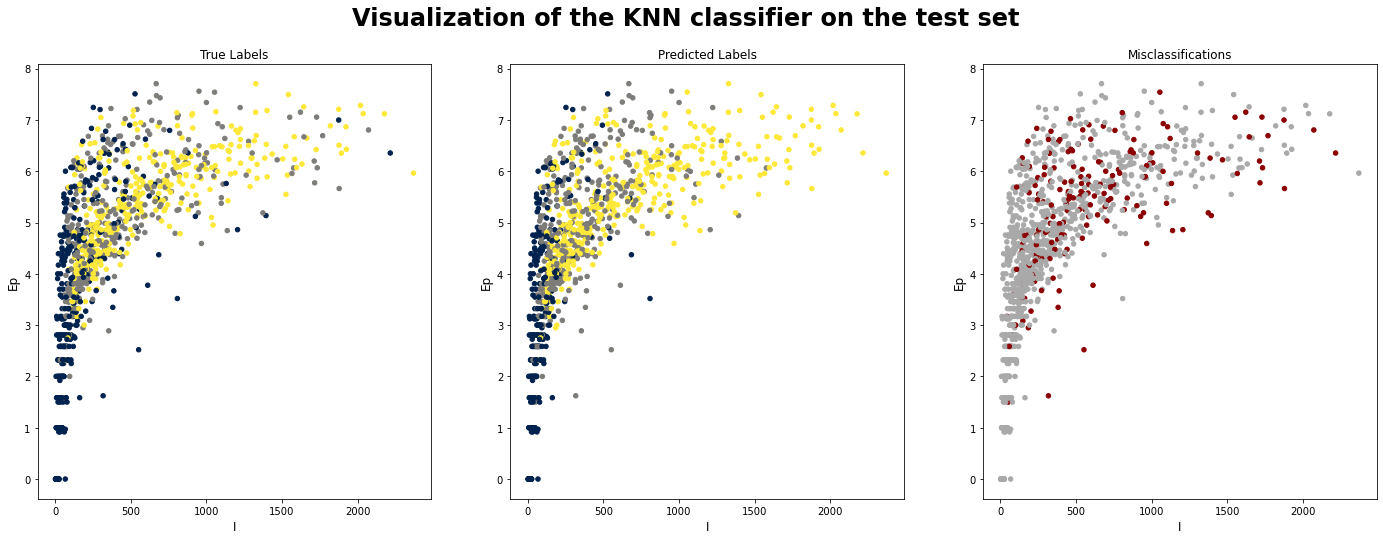

In [92]:
classification_visualizer(test_set, test_label, test_pred_knn, 'KNN')

The comparison between the two plots (true labels and those predicted by the model) as well as the visualization of the misclassified points, allows us to note that **this model is quite accurate** as it did not make excessive errors in the prediction.

##### Confusion Matrix of the classifier
Here we display the confusion matrix referring to the classifier performance.

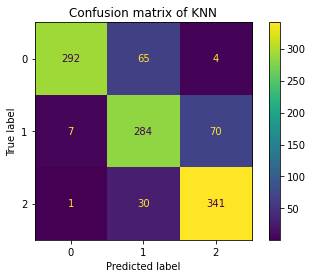

In [93]:
plot_c_matrix(test_set, test_label, test_pred_knn, knn, 'KNN')

The class that reports the major number of errors is that of medium spending, erroneously classified most often as high spending.

##### Visualization of the decision boundary of the classifier

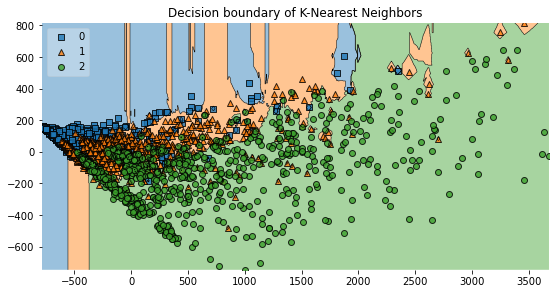

In [94]:
plot_decision_boundary(train_set, train_label, knn, 'K-Nearest Neighbors')

The decision boundaries drawn by this model for our data are very precise: we will see, by comparing this plot with those of the following models, that the hyperplane found by knn to separate data into the three classes is one of the best in this notebook.

##### ROC Curve of the classifier

In [95]:
# probabilities
# test_pred_proba_knn = knn.predict_proba(test_set)

ValueError: query data dimension must match training data dimension

In [96]:
import scikitplot as skplt
# skplt.metrics.plot_roc(test_label, test_pred_proba_knn)

NameError: name 'test_pred_proba_knn' is not defined

### Radius-Neighbors Classifier 

In cases where the record from the dataset tends to be not uniformly sampled, Radius-based Neighbors Classification can provide better results.

#### Import libraries

In [97]:
from sklearn.neighbors import RadiusNeighborsClassifier

#### Grid search

We utilize again the grid search in order to identify the optimal values for classifier parameters. These parameters are for the most part the same calculated for the KNN classifier, the only difference lies in the replacement of the parameter k, number of neighbors, with the parameter r, the radius within which to search for neighbors.

We set up a range of possible values for r and perform the actual grid search.

In [98]:
from scipy.stats import uniform
#radius = np.arange(1.0, 100000.0, 0.1)
radius = uniform(1.0, 10000000.0)
radius_param_grid = {
    'radius': radius,
    'metric': knn_metrics,
    'algorithm': knn_algorithms,
    'weights': knn_weights
            }

In [99]:
radius_grid = RandomizedSearchCV(RadiusNeighborsClassifier(), radius_param_grid, n_jobs=-1, n_iter = 100, cv=10, scoring='accuracy')
#radius_grid = GridSearchCV(RadiusNeighborsClassifier(), radius_param_grid, scoring=make_scorer(accuracy_score), cv=10)
radius_grid.fit(train_set, train_label)

RandomizedSearchCV(cv=10, estimator=RadiusNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'brute'],
                                        'metric': ['euclidean', 'manhattan'],
                                        'radius': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021B000764C0>,
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy')

After fitting the model to the dataset, the search results is these values for the parameters and the accuracy of the classifier. 

In [100]:
# examine the best model
print('Accuracy: ' + str(radius_grid.best_score_))
print('Parameters: ' + str(radius_grid.best_params_))

Accuracy: 0.7609497549019608
Parameters: {'algorithm': 'brute', 'metric': 'euclidean', 'radius': 9716121.81057712, 'weights': 'distance'}


Once again we proceed with the fitting, testing and evaluation of the model. 

#### Fitting the classifier

In [101]:
radius = RadiusNeighborsClassifier(**radius_grid.best_params_).fit(train_set, train_label)

#### Test

In [102]:
#prediction on the test test
test_pred_radius = radius.predict(test_set)

#### Evaluation

In [103]:
report_scores(test_label,test_pred_radius)

                 precision    recall  f1-score   support

   low_spending       0.85      0.78      0.81       361
medium-spending       0.61      0.62      0.61       361
  high-spending       0.76      0.80      0.77       372

       accuracy                           0.73      1094
      macro avg       0.74      0.73      0.73      1094
   weighted avg       0.74      0.73      0.73      1094



In this case the value of accuracy for the model is quite good enough, but not excellent.

The metrics (precision, recall and f1-score) confirms again to be the best for the low-spending class.

##### Visualization of the classifier results via scatterplots

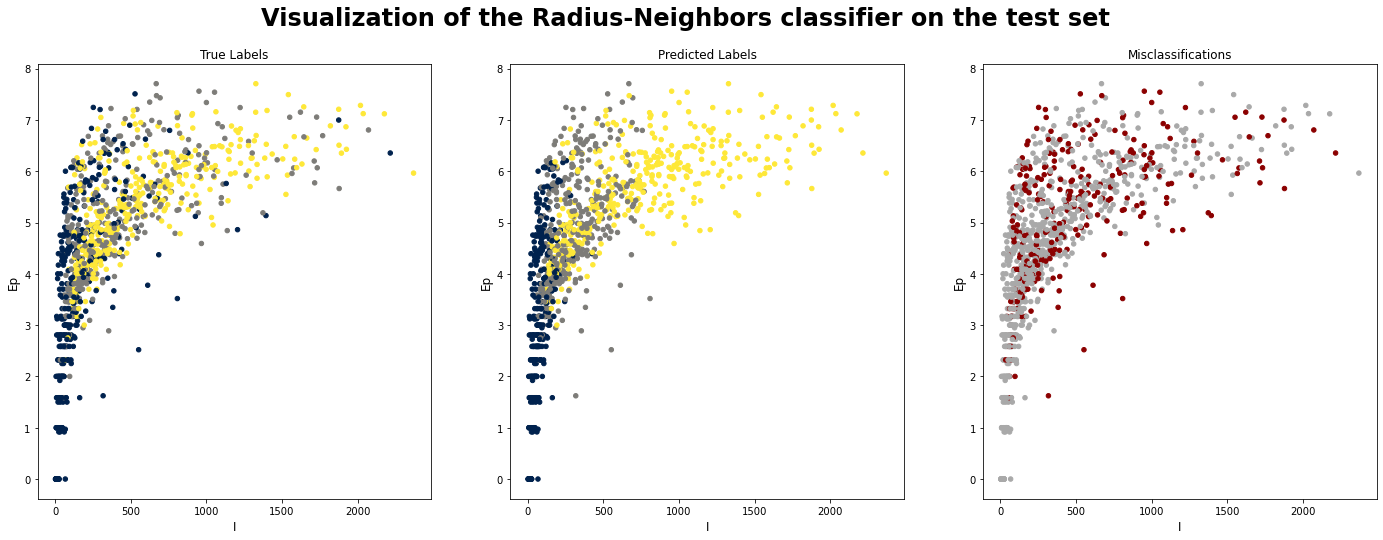

In [104]:
classification_visualizer(test_set, test_label, test_pred_radius, 'Radius-Neighbors')

The comparison between the two plots (true labels and those predicted by the model) as well as the visualization of the misclassified points, allows us to note that the raius classifier is quite good, but the previuous knn model performed better.

##### Confusion Matrix of the classifier

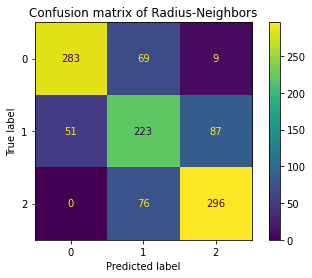

In [105]:
plot_c_matrix(test_set, test_label, test_pred_radius, radius, 'Radius-Neighbors')

Again, the class that got more errors is that of medium spending, erroneously classified most often as high spending.

##### Visualization of the decision boundary of the classifier

In [106]:
#plot_decision_boundary(train_set, train_label, radius, 'Radius-Neighbors')

##### ROC Curve of the classifier

In [107]:
# probabilities
test_pred_proba_radius = radius.predict_proba(test_set)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

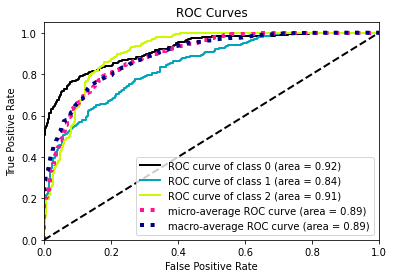

In [108]:
import scikitplot as skplt
skplt.metrics.plot_roc(test_label, test_pred_proba_radius)

### Classification with Naive Bayes
This approach is one of the simplest, fastest and most popular classification techniques.

It is called "naive" because the starting hypotheses are very simplified. In fact, the algorithm has as premise a simplifying assumption: it considers the features of the model to be **independent from each other.**
Although this is useful for the application of the algorithm and for learning, we know that this assumption is not always representative of reality: in the real world the features of the data are often dependent and correlated.

#### How the algorithm works
Naive Bayes is a classification algorithm based on the application of **Bayes Theorem:**


$P(C|E) = \frac{P(E | C) P(C)}{P(E)} $

Where:
* $C$ denotes a class variable.
* $E$ is the evidence (i.e. the distribution of the sets of attributes), so the informations we derived from data.
* $P(C)$ is the prior probability of $C$ (does not take into account any information about $E$).
* $P(E)$ is the prior probability of the evidence $E$, and it acts as normalising constant.
* $P(C|E)$ is the conditioned probability of $C$, given the evidence $E$, aka **posterior probability**. It represents the probability of being assigned to the class $C$, knowing the distribution of attributes (i.e. knowing the evidence).
* $P(E|C)$ is the **likelihood**, so what we want to maximize. It represents the conditioned probability of $E$, given the evidence $C$


It is clear from this definition that Bayes theorem combines a **prior probability** with **knowledge deriving from data** (the evidence).

So since Naive Bayes classifiers is a based on a probabilistic approach, it provides a probability to be classified, i.e. the probability for each data point to belong to a certain class. Its aim is to **learn the posterior probability**, i.e. maximize the likelihood.

The algorithm computes all the posterior probabilities and it **chooses the label with the higher probability.**


### Gaussian Naive Bayes
[Scikit GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB) implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian. By assuming the data to have a Gaussian distribution, we can estimate the parameter for this distribution (that are mean $\mu$ and variance $\sigma$) using maximum likelihood.


Since we aren't going to specify prior probabilities of the classes (because we want them to be adjusted according to the data) grid search for GNB model is not needed.

#### Import libraries

In [109]:
from sklearn.naive_bayes import GaussianNB

#### Fitting and testing the model

In [110]:
gnb = GaussianNB()
gnb.fit(train_set, train_label)

GaussianNB()

In [111]:
#predict on the training set
train_pred_gnb = gnb.predict(train_set)

In [112]:
#predict on the test set
test_pred_gnb = gnb.predict(test_set)

#### Probabilities

Since we have said that Naive Bayes Classifier assigns a probability for each data point to belong to a certain class, here you can clearly see those probabilities, estimated for the test set:

In [113]:
test_pred_proba_gnb = gnb.predict_proba(test_set)
test_pred_proba_gnb

array([[3.34850257e-06, 6.79981563e-01, 3.20015089e-01],
       [7.05628352e-03, 9.58796734e-01, 3.41469823e-02],
       [9.98743827e-01, 1.25373554e-03, 2.43716315e-06],
       ...,
       [9.99156270e-01, 8.43124309e-04, 6.05849982e-07],
       [1.55965557e-12, 1.38740265e-01, 8.61259735e-01],
       [5.34106118e-05, 9.34828071e-01, 6.51185187e-02]])

#### Evaluation

##### Model performance on the training set

In [114]:
#compute the performance of the model
print ('GNB performance on train set: \n')
report_scores(train_label, train_pred_gnb)

GNB performance on train set: 

                 precision    recall  f1-score   support

   low_spending       0.64      0.85      0.73       842
medium-spending       0.48      0.41      0.44       842
  high-spending       0.77      0.62      0.69       868

       accuracy                           0.63      2552
      macro avg       0.63      0.63      0.62      2552
   weighted avg       0.63      0.63      0.62      2552



##### Model performance on the test set

In [115]:
#compute the performance of the model
print ('GNB performance on test set: \n')
report_scores(test_label,test_pred_gnb)

GNB performance on test set: 

                 precision    recall  f1-score   support

   low_spending       0.66      0.81      0.73       361
medium-spending       0.44      0.39      0.41       361
  high-spending       0.71      0.61      0.66       372

       accuracy                           0.61      1094
      macro avg       0.60      0.61      0.60      1094
   weighted avg       0.60      0.61      0.60      1094



It can be easily understood from the performance of the model that the results are not optimal. We expected a similar result since the Naive Bayes classifier is a very simple model, perhaps too much simple for a dataset like ours.

##### Model performance on the training set

In [116]:
#evaulate the accuracy on the train set 
#metrics also contains precision, recall, f1 and the support

print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_gnb))
print('Precision train set ', metrics.precision_score(train_label, train_pred_gnb, average='weighted'))
print('Recall train set ', metrics.recall_score(train_label, train_pred_gnb, average='weighted'))
print('F1 score train set ', metrics.f1_score(train_label, train_pred_gnb, average='weighted'))
print('Support train set ', metrics.precision_recall_fscore_support(train_label, train_pred_gnb))

Accuracy train set  0.6293103448275862
Precision train set  0.6308378998878369
Recall train set  0.6293103448275862
F1 score train set  0.6216004727925039
Support train set  (array([0.6399287 , 0.47534247, 0.77285714]), array([0.85273159, 0.41211401, 0.62327189]), array([0.7311609 , 0.44147583, 0.69005102]), array([842, 842, 868], dtype=int64))


##### Model performance on the test set

In [117]:
#evaulate the accuracy on the test set
#metrics also contains precision, recall, f1 and the support
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_gnb))
print('Precision test set ', metrics.precision_score(test_label, test_pred_gnb, average='weighted'))
print('Recall test set ', metrics.recall_score(test_label, test_pred_gnb, average='weighted'))
print('F1 score test set ', metrics.f1_score(test_label, test_pred_gnb, average='weighted'))
print('Support test set ', metrics.precision_recall_fscore_support(test_label, test_pred_gnb))

Accuracy test set  0.6060329067641682
Precision test set  0.6009441682116909
Recall test set  0.6060329067641682
F1 score test set  0.5992314895541401
Support test set  (array([0.65548098, 0.4382716 , 0.70588235]), array([0.81163435, 0.3933518 , 0.61290323]), array([0.72524752, 0.41459854, 0.65611511]), array([361, 361, 372], dtype=int64))


##### Visualization of the classifier results via scatterplots
Here you can clearly see the true test labels, the prediction made by the Gaussian Naive Bayes classfier and the misclassified points (i.e. the errors that the model made).

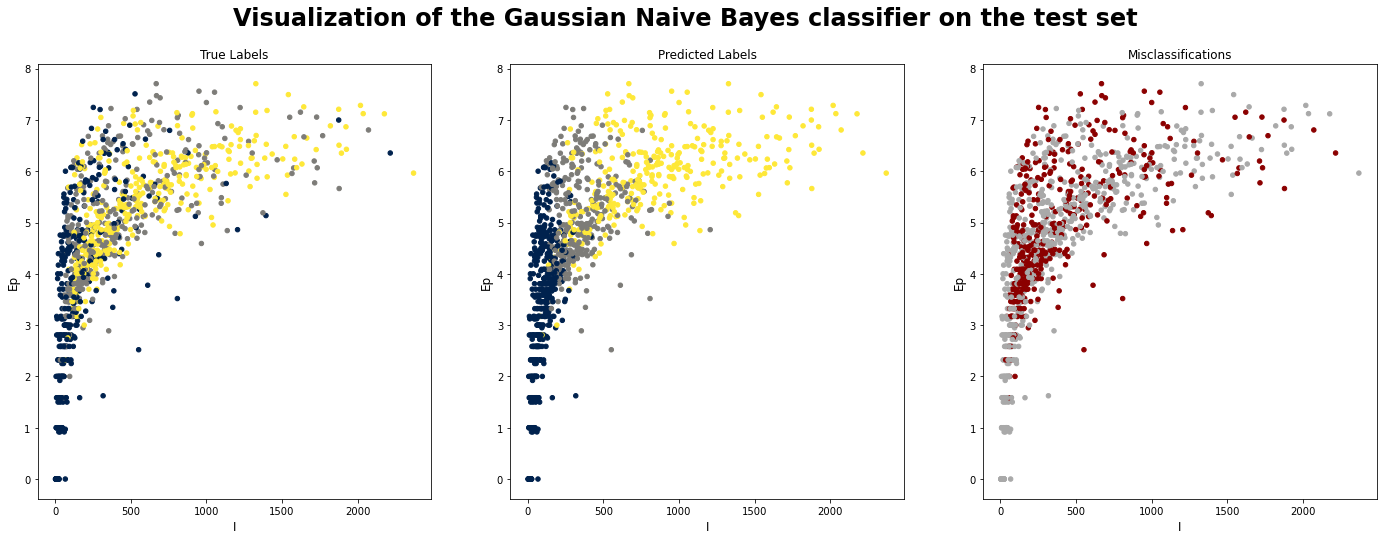

In [118]:
classification_visualizer(test_set, test_label, test_pred_gnb, 'Gaussian Naive Bayes')

##### Confusion Matrix of the classifier

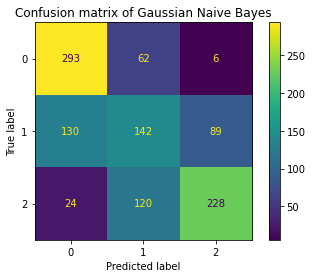

In [119]:
plot_c_matrix(test_set, test_label, test_pred_gnb, gnb, 'Gaussian Naive Bayes')

Again, the class that reports more errors is that of medium spending, but in this case it is erroneously classified most often as low spending.

##### Visualization of the decision boundary of the classifier

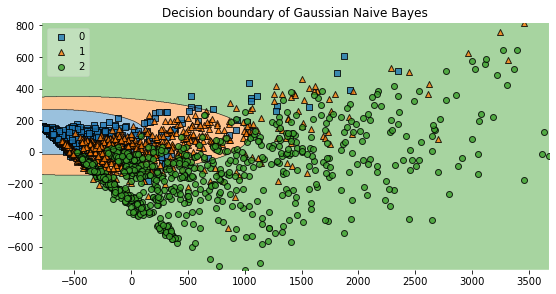

In [120]:
plot_decision_boundary(train_set, train_label, gnb, 'Gaussian Naive Bayes')

The decision boundaries drawn by this model for our data are **elliptic**: this confirms what was previously said about the **excessive simplicity of this model, which is not able to fit complex data like ours**.

##### ROC curve of the classifier

In [121]:
test_set.shape

(1094, 11)

In [122]:
test_pred_proba_gnb.shape

(1094, 3)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

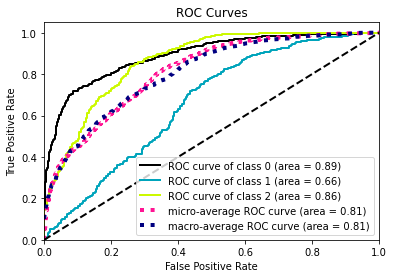

In [123]:
skplt.metrics.plot_roc(test_label, test_pred_proba_gnb)

### Multinomial Naive Bayes
[Scikit MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) implements the naive Bayes algorithm for multinomially distributed data. It is often used in text classification.

The distribution is parametrized by vectors $\theta_c = (\theta_{c1}, ..., \theta_{cn})$
for each class $c$, where $n$ is the number of features and $\theta_{ci}$ is the probability $P(x_i | c)$
of feature $i$ belonging to class $c$ .

The parameters $\theta_c$ is estimated by a smoothed version of maximum likelihood.

#### Laplacian Estimator

We have seen during lectures that, in the Naive Bayes classifiers, if one of the conditional probability is zero, the entire expression becomes zero. In order to prevent that, we can use the Laplacian estimator (like in rule-based classifiers).


The smoothing priors $\alpha \geq 0$ accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting $\alpha =1 $ is called Laplace smoothing, while $\alpha <1$ is called Lidstone smoothing.

#### Import libraries

In [124]:
from sklearn.naive_bayes import MultinomialNB

#### Grid Search
Since we want to find the best value of the $\alpha$ parameter for this model, we think that a (brief) grid search is needed.

In [125]:
param_dist = {
    "alpha": [0,1,2,3,5,6,7,8,9] # Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).
        } 
              
#define the number of iters
n_iter_search = 50
#define the model
clf = MultinomialNB() # The number of trees in the forest

#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search

grid_search.fit(train_set, train_label)

C:\Users\Diletta\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(estimator=MultinomialNB(), n_iter=50, n_jobs=10,
                   param_distributions={'alpha': [0, 1, 2, 3, 5, 6, 7, 8, 9]},
                   scoring=make_scorer(accuracy_score))

Print the best set of hyperparameters for this dataset.

In [126]:
print('Best setting parameters\n', grid_search.cv_results_['params'][0])
print('\nMean of this setting\n', grid_search.cv_results_['mean_test_score'][0], 
      '\n\nStandard Deviation (std) of this setting\n', grid_search.cv_results_['std_test_score'][0])

Best setting parameters
 {'alpha': 0}

Mean of this setting
 0.5846360461993017 

Standard Deviation (std) of this setting
 0.013947499948050711


#### Fitting and testing the model

In [127]:
#import, define and fit the model
mnb = MultinomialNB(alpha=0)
mnb.fit(train_set, train_label)

C:\Users\Diletta\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


MultinomialNB(alpha=0)

In [128]:
#predict on the train set
train_pred_mnb = mnb.predict(train_set)
train_pred_mnb

array([2, 0, 1, ..., 0, 0, 2])

In [129]:
#predict on the test set
test_pred_mnb = mnb.predict(test_set)
test_pred_mnb

array([2, 1, 0, ..., 0, 1, 1])

These are the final model parameters:

In [130]:
mnb.get_params()

{'alpha': 0, 'class_prior': None, 'fit_prior': True}

#### Probabilities

Since we have said that Naive Bayes Classifier assigns a probability for each data point to belong to a certain class, here you can clearly see those probabilities, estimated for the test set:

In [131]:
test_pred_proba_mnb = mnb.predict_proba(test_set)
test_pred_proba_mnb

array([[2.92057200e-10, 5.60192053e-13, 1.00000000e+00],
       [2.32955353e-18, 9.99997649e-01, 2.35074855e-06],
       [1.00000000e+00, 6.21813843e-12, 2.20733444e-15],
       ...,
       [1.00000000e+00, 2.41746436e-12, 3.00759310e-14],
       [3.86919046e-43, 5.59591320e-01, 4.40408680e-01],
       [8.77855577e-34, 1.00000000e+00, 1.32248909e-22]])

#### Evaluation

##### Model performance on the training set

In [132]:
#compute the performance of the model
print ('GNB performance on train set: \n')
report_scores(train_label,train_pred_mnb)

GNB performance on train set: 

                 precision    recall  f1-score   support

   low_spending       0.55      0.83      0.66       842
medium-spending       0.50      0.33      0.40       842
  high-spending       0.74      0.63      0.68       868

       accuracy                           0.59      2552
      macro avg       0.60      0.59      0.58      2552
   weighted avg       0.60      0.59      0.58      2552



##### Model performance on the test set

In [133]:
#compute the performance of the model
print ('GNB performance on test set: \n')
report_scores(test_label,test_pred_mnb)

GNB performance on test set: 

                 precision    recall  f1-score   support

   low_spending       0.56      0.79      0.66       361
medium-spending       0.51      0.37      0.43       361
  high-spending       0.73      0.62      0.67       372

       accuracy                           0.60      1094
      macro avg       0.60      0.59      0.58      1094
   weighted avg       0.60      0.60      0.59      1094



The performance of this model confirms what has been said above for Gaussian classifier: since they are very simple models, they do not perform optimally on our data and this justifies the obtained results.

We will see later that more complex models have better results on our dataset.

##### Visualization of the classifier results via scatterplots
Here you can clearly see the true test labels, the prediction made by the Multinomial Naive Bayes classfier and the misclassified points (i.e. the errors that the model made).

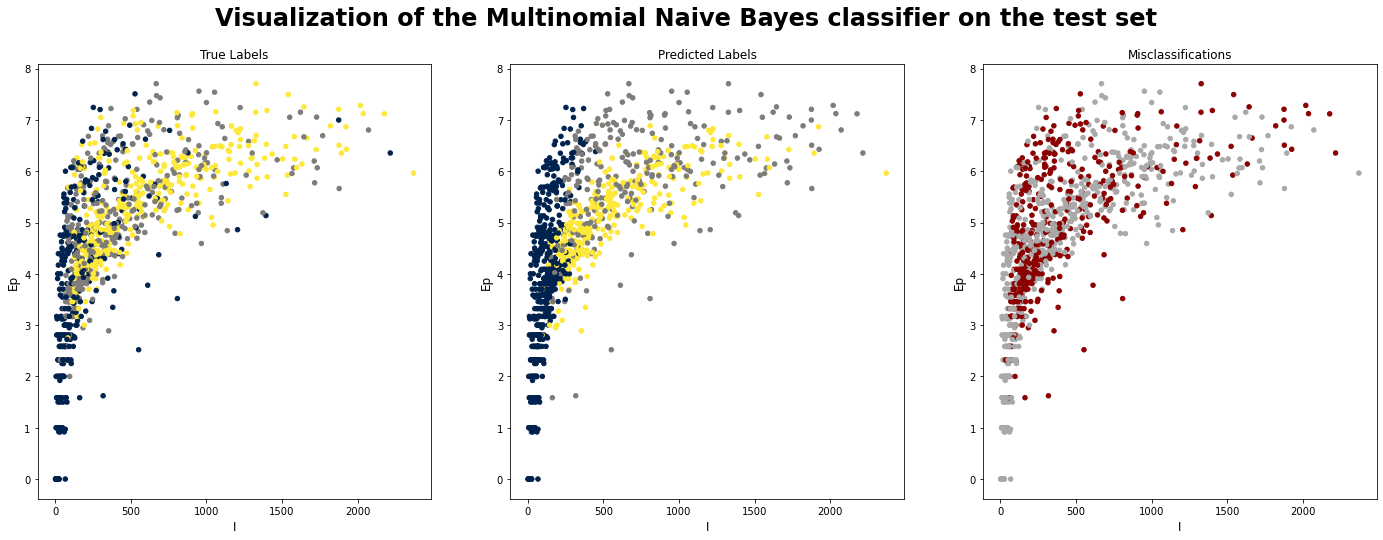

In [134]:
classification_visualizer(test_set, test_label, test_pred_mnb, 'Multinomial Naive Bayes')

##### Confusion Matrix of the classifier

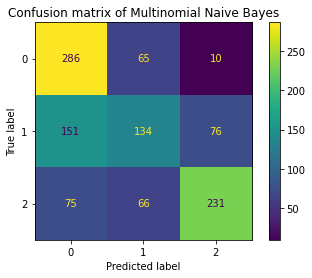

In [135]:
plot_c_matrix(test_set, test_label, test_pred_mnb, mnb, 'Multinomial Naive Bayes')

As in the previous case, the class that reports more errors is that of medium spending, erroneously classified more often as low spending.

##### Visualization of the decision boundary of the classifier

In [136]:
#plot_decision_boundary(train_set, train_label, mnb, 'Multinomial Naive Bayes')

##### ROC curve of the classifier

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

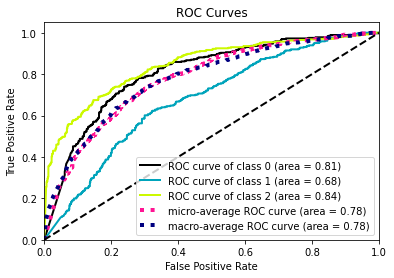

In [137]:
skplt.metrics.plot_roc(test_label, test_pred_proba_mnb)

#### Naive Bayes final considerations 

Naive Bayes classifiers are certainly not the best for this type of data and features: in fact they are too simple models and they cannot perform well.

##### Pros
- Robust to isolated noise points
- Handle missing values by ignoring the instance during probability estimate calculations
- Robust to irrelevant attributes (because it follows a probabilistic approach)

It must be said that, in this context, these advantages do not have much relevance: in fact, our dataset has already been deeply cleaned up during Task 1, and it is therefore already free of outliers, noise and missing values.

##### Cons
- Independence assumption may not hold for some attributes

In our case, the problem of highly correlated features does not arise as they have already been eliminated during the preprocessing of Task 2.

### Support Vector Classification

[Scikit Support Vector Classification](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) is a model that select the **best decision boundary** to separate data.

SVM represents the decision boundary using a subset of the training examples, known as the support vectors.

#### Import libraries

In [138]:
from sklearn.svm import SVC

#### Grid search 

Since this classifier has many parameters, a grid search is required.

However, we were unable to run the code written below and run it, as it is far too complex.
The combinations of possible values for each parameter, in fact, are too many. 

So we decided to fit two SVM models with two different kernel types: we focused our attention on the *kernel* parameter as it is what determines the shape of the decision boundaries.


In [139]:
'''
param_dist = {"kernel": ['rbf', 'sigmoid'], # fondamentale per plottare le regioni di piano
              "C": sp_randint(1, 10),
              "gamma": ["scale", "auto"], # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
              "probability": [True, False], # Whether to enable probability estimates. 
              "class_weight":['balanced', None]}
#define the number of iters
n_iter_search = 20
#define the model
clf = SVC()
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score), verbose=5)
#run the grid search
grid_search.fit(train_set, train_label)

print('Best setting parameters\n', grid_search.cv_results_['params'][0])
print('\nMean of this setting\n', grid_search.cv_results_['mean_test_score'][0], 
      '\n\nStandard Deviation (std) of this setting\n', grid_search.cv_results_['std_test_score'][0])
'''

'\nparam_dist = {"kernel": [\'rbf\', \'sigmoid\'], # fondamentale per plottare le regioni di piano\n              "C": sp_randint(1, 10),\n              "gamma": ["scale", "auto"], # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.\n              "probability": [True, False], # Whether to enable probability estimates. \n              "class_weight":[\'balanced\', None]}\n#define the number of iters\nn_iter_search = 20\n#define the model\nclf = SVC()\n#define the grid search\ngrid_search = RandomizedSearchCV(clf, param_distributions=param_dist, \n                            n_iter=n_iter_search, \n                            n_jobs=10, \n                            scoring=make_scorer(accuracy_score), verbose=5)\n#run the grid search\ngrid_search.fit(train_set, train_label)\n\nprint(\'Best setting parameters\n\', grid_search.cv_results_[\'params\'][0])\nprint(\'\nMean of this setting\n\', grid_search.cv_results_[\'mean_test_score\'][0], \n      \'\n\nStandard Deviation (std) of this 

N.B. 
- The C parameter in the model is a regularization parameter. The strength of the regularization is inversely proportional to C.
- The *gamma* parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The *gamma* parameter can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

#### Fitting and running the model

SVC implement the “one-versus-one” approach for multi-class classification. In total, *n_classes * (n_classes - 1) / 2* classifiers are constructed and each one trains data from two classes. To provide a consistent interface with other classifiers, the *decision_function_shape* option allows to monotonically transform the results of the “one-versus-one” classifiers to a “one-vs-rest” decision function of shape (n_samples, n_classes).

In [140]:
svm = SVC(kernel='rbf', C=0.5, gamma='scale', probability=True, decision_function_shape='ovo')

In [141]:
svm.fit(train_set, train_label)

SVC(C=0.5, decision_function_shape='ovo', probability=True)

In [142]:
svm_sigm = SVC(kernel='sigmoid', C=0.5, gamma='scale', probability=True, decision_function_shape='ovo')

In [143]:
svm_sigm.fit(train_set, train_label)

SVC(C=0.5, decision_function_shape='ovo', kernel='sigmoid', probability=True)

##### Training

In [144]:
train_pred_svm = svm.predict(train_set)
train_pred_svm_sigm = svm_sigm.predict(train_set)

##### Testing

In [145]:
test_pred_svm = svm.predict(test_set)
test_pred_svm_sigm = svm_sigm.predict(test_set)

##### Probabilities
Sinche we enabled probability estimates for the model (i.e. we set the *probability* parameter as True) we can visualize them.

In [146]:
test_pred_proba_svm = svm.predict_proba(test_set)

In [147]:
test_pred_proba_svm_sigm = svm_sigm.predict_proba(test_set)

#### Evaluation

##### Model performance on the training set (with rbf kernel)

In [148]:
print ('SVM with rbf kernel: \n')
print(classification_report(train_label, train_pred_svm, target_names=class_names))

SVM with rbf kernel: 

                 precision    recall  f1-score   support

   low-spending       0.85      0.82      0.84       842
medium-spending       0.69      0.71      0.70       842
  high-spending       0.84      0.85      0.85       868

       accuracy                           0.80      2552
      macro avg       0.80      0.79      0.80      2552
   weighted avg       0.80      0.80      0.80      2552



##### Model performance on the training set (with sigmoid kernel)

In [149]:
print ('SVM with sigmoid kernel: \n')
print(classification_report(train_label, train_pred_svm_sigm, target_names=class_names))

SVM with sigmoid kernel: 

                 precision    recall  f1-score   support

   low-spending       0.61      0.93      0.73       842
medium-spending       0.32      0.25      0.28       842
  high-spending       0.67      0.47      0.55       868

       accuracy                           0.55      2552
      macro avg       0.53      0.55      0.52      2552
   weighted avg       0.54      0.55      0.52      2552



##### Model performance on the test set (with rbf kernel)

In [150]:
print ('SVM with rbf kernel: \n')
print(classification_report(test_label, test_pred_svm, target_names=class_names))


SVM with rbf kernel: 

                 precision    recall  f1-score   support

   low-spending       0.87      0.80      0.83       361
medium-spending       0.63      0.68      0.65       361
  high-spending       0.79      0.79      0.79       372

       accuracy                           0.76      1094
      macro avg       0.76      0.76      0.76      1094
   weighted avg       0.76      0.76      0.76      1094



##### Model performance on the test set (with sigmoid kernel)

In [151]:
print ('SVM with sigmoid kernel: \n')
print(classification_report(test_label, test_pred_svm_sigm, target_names=class_names))

SVM with sigmoid kernel: 

                 precision    recall  f1-score   support

   low-spending       0.61      0.90      0.73       361
medium-spending       0.35      0.29      0.32       361
  high-spending       0.66      0.45      0.54       372

       accuracy                           0.55      1094
      macro avg       0.54      0.55      0.53      1094
   weighted avg       0.54      0.55      0.53      1094



It is easy to see that the performance of this model with *kernel = rbf* (Radial Basis Function) is very good. In fact, SVM is a much more complete and complex type of classifier than Naive Bayes, and therefore we expected it to be able to classify our data with few errors and with satisfying accuracy. The results of the prediction both on the training and on the test set exactly confirm our expectations.

##### Visualization of the classifier results via scatterplots

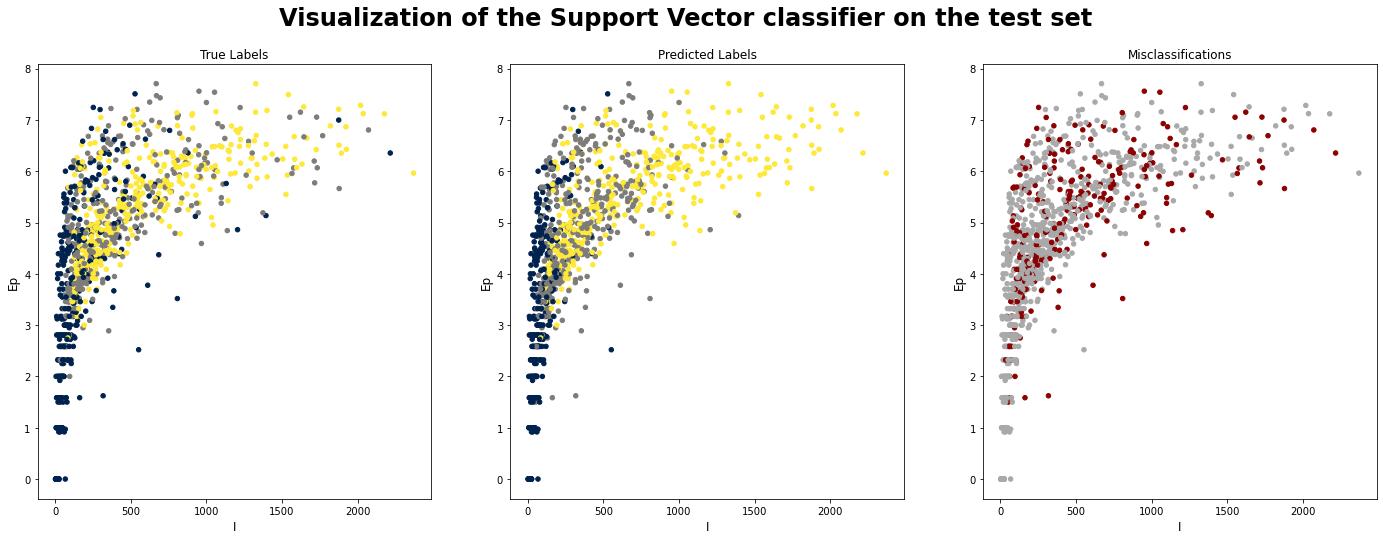

In [152]:
classification_visualizer(test_set, test_label, test_pred_svm, 'Support Vector')

The comparison between the two plots (true labels and those predicted by the model) as well as the visualization of the misclassified points, allows us to note that SVM classifier with RBF kernel is quite accurate as it did not make excessive errors in the prediction.

##### Confusion Matrix of the classifier

In [153]:
#plot_c_matrix(test_set, test_label, test_pred_svm, svm, 'Support Vector')

##### Visualization of the decision boundary of the classifier

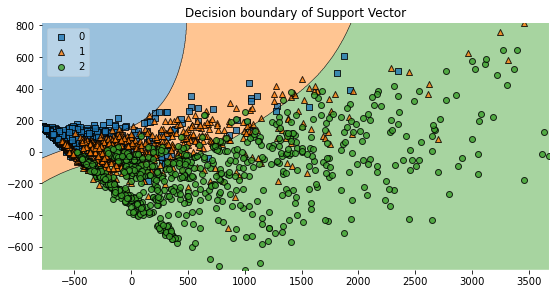

In [154]:
plot_decision_boundary(train_set, train_label, svm, 'Support Vector')

The decision boundaries drawn by this model for our data are quite precise: it must be said that they strongly depends on the type of kernel. 

Maybe, with the opportunity to run the grid search, we could have found even better configurations of parameter and so we could have obtained a better hyperplane to separate data into classes.

##### ROC curve of the classifier

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

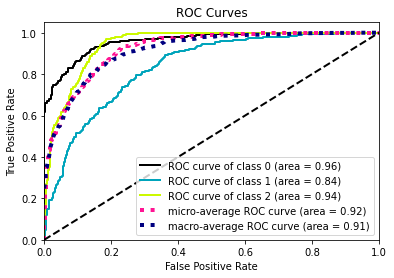

In [155]:
skplt.metrics.plot_roc(test_label, test_pred_proba_svm)

#### Comments on SVM classifier 

The only obstacle we faced while running the model was the grid search. The excessive complexity did not allow us to compute the best configuration of parameters for this model.

However, SVM confirms to be as a very powerful model for data classification, even with high number of features and so high-dimensionality of the dataset.

SVM performances far exceed those of the two Naive Bayes classifiers.

##### Advantages

- Effective in high dimensional spaces.
- Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.

- Versatile: different Kernel functions can be specified for the decision function. 

##### Disadvantages

- If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
- SVMs do not directly provide probability estimates, these are computed using an expensive five-fold cross-validation.

## Neural models


We present here two different models based on Neural Networks:
- a **Feed-forward NN**, that we built using the Keras Classifier model, by adding different layers.
- a **Multi-layer perceptron**, a very famous ML model.

### Feed-forward Neural Network

A multi-layer neural network can solve any type of classification tasks.

In our case, we want the output layer to create 3 output values, one for each class. The output value with the largest value will be taken as the class predicted by the model.

We use a *softmax* activation function in the output layer. This is to ensure the output values are in the range of 0 and 1 and may be used as predicted probabilities.

#### Import libraries

In [156]:
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#### Grid search
In order to perform the grid search on our Neural Network we need the help of a model called Keras Classifier.

In [157]:
# define baseline model
def baseline_model(optimizer = 'adam', init_mode='uniform', activation='relu', dropout_rate=0.2, neurons=8, loss='categorical_crossentropy'): #specify parameters so that we can do grid search
    # create model
    model = Sequential()
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, kernel_initializer=init_mode, activation='softmax'))
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [158]:
# create model
nn = KerasClassifier(build_fn=baseline_model, verbose=0)

In this case we would have liked to perform a more complete search to find the best parameter configuration for the Neural Network, but the excessive complexity (and previous experience with the SVM model) led us to select fewer possible values ​​for the parameters, as well as to fix some.

In [160]:
from scipy.stats import uniform
from scipy.stats import randint

#Tune Batch Size and Number of Epochs
batch_size = [500]
epochs = [100]

# Tune the Training Optimization Algorithm
optimizer = ['SGD', 'adam', 'adamax'] # Tune the Training Optimization Algorithm

#Tune the Neuron Activation Function
activation = ['softmax', 'relu', 'sigmoid', 'linear']

#Tune Dropout Regularization
dropout_rate = [0.2]

#Tune the Number of Neurons in the Hidden Layer
neurons = randint(5, 20)

#Tune the Loss function
loss = ['binary_crossentropy', 'mean_squared_error', 'categorical_crossentropy']

param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer, 
                  activation=activation, dropout_rate=dropout_rate, neurons=neurons, loss=loss) 

#grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv=3, verbose=5)
grid = RandomizedSearchCV(estimator=nn, param_distributions=param_grid, n_iter=100, n_jobs=-1, cv=3, verbose=5)
y_train = np.asarray(train_label).astype('float32').reshape((-1,1))
#y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))
#grid_result = grid.fit(train_set, train_label)
grid_result = grid.fit(train_set, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   41.4s finished


In [161]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.447518 using {'activation': 'linear', 'batch_size': 500, 'dropout_rate': 0.2, 'epochs': 100, 'loss': 'mean_squared_error', 'neurons': 9, 'optimizer': 'SGD'}


#### Run again the NN with the best configuration of parameters for 9 neurons 

In [170]:
# define baseline model
def baseline_model(optimizer = 'adam', init_mode='uniform', activation='relu', dropout_rate=0.2, neurons=8, loss='categorical_crossentropy'): #specify parameters so that we can do grid search
    # create model
    model = Sequential()
    model.add(Dense(neurons, kernel_initializer=init_mode, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, kernel_initializer=init_mode, activation='softmax'))
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [171]:
# create model
nn = KerasClassifier(build_fn=baseline_model, verbose=0)

In [172]:
history = nn.fit(train_set.values, train_label,
                    epochs=120,
                    batch_size=500,
                    validation_split=0.2)

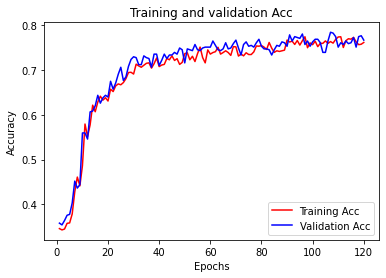

In [173]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Acc', c='r')
plt.plot(epochs, val_acc, 'b', label='Validation Acc', c='b')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the curve we can observe how the accuracy improves both for training and for the test set, even if its zig-zag behavior suggests that the learning is good but not optimal.

In [174]:
test_pred_nn = nn.predict(test_set)

C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


##### Model performance on the test set

In [175]:
#compute the performance of the model
report_scores(test_label, test_pred_nn)

                 precision    recall  f1-score   support

   low_spending       0.86      0.84      0.85       361
medium-spending       0.72      0.59      0.65       361
  high-spending       0.76      0.91      0.83       372

       accuracy                           0.78      1094
      macro avg       0.78      0.78      0.78      1094
   weighted avg       0.78      0.78      0.78      1094



The accuracy of the model is good and, again, the classes that confirm to have the best values of the other metrics are low-spending and high-spending

##### Visualization of the classifier results via scatterplots

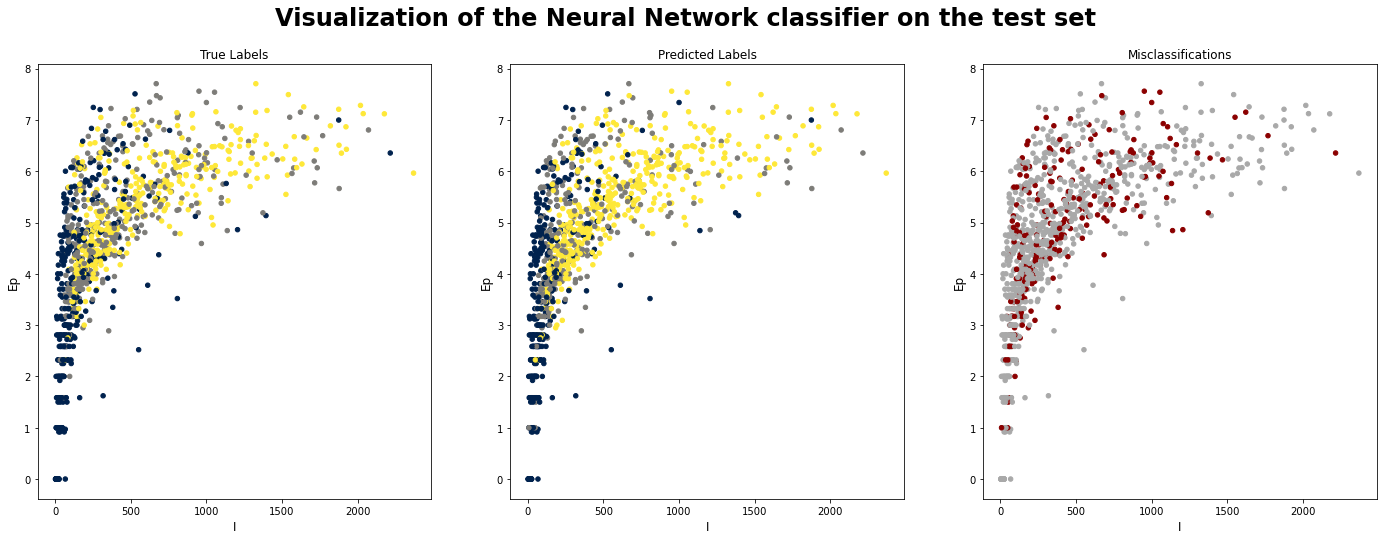

In [176]:
classification_visualizer(test_set, test_label, test_pred_nn, 'Neural Network')

The comparison between the two plots (true labels and those predicted by the model) as well as the visualization of the misclassified points, allows us to note that the Feed-forward NN is quite accurate as it did not make excessive errors in the prediction.

##### Confusion Matrix of the classifier

Unfortunately we cannot plot the confusion matrix for the Keras Classifiers, because this option is not supported by this model.

##### Visualization of the decision boundary of the classifier

C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


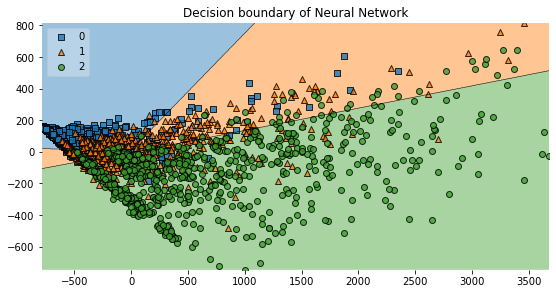

In [178]:
plot_decision_boundary(train_set, train_label, nn, 'Neural Network')

The decision boundaries drawn by this model for our data are very precise: in fact we know from the literature that Neural Networks are really powerful model for classification (and not only) and so even a really simple feed-forward one is able to find satisfying hyperplane to separate data.

##### ROC curve of the classifier

In [179]:
#test_pred_proba_nn = nn.predict_proba(test_set)

C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


ValueError: in user code:

    C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Diletta\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\input_spec.py:255 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer sequential_4 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape (None, 11)


In [ ]:
#skplt.metrics.plot_roc(test_label, test_pred_proba_nn)


### Multi-layer Perceptron
[Scikit MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) implements a multi-layer perceptron (MLP) algorithm that trains using Backpropagation. Is one of the (supervised) Neural network models of scikit-learn.

#### How the algorithm works
MLP is a supervised learning algorithm that learns a function $f(\cdot): R^m \rightarrow R^o$
by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = x_1, x_2, ..., x_m$
and a target $y$, it can learn a non-linear function approximator for classification. 

#### Import libraries

In [196]:
from sklearn.neural_network import MLPClassifier

#### Pre-processing
Multi-layer Perceptron is sensitive to feature scaling, so we have to scale our data. In this case we use StandardScaler for standardization.

It is important to apply the same scaling to the test set for meaningful results. 


In [197]:
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler()  
X_train = train_set
scaler.fit(X_train)  
X_train = scaler.transform(X_train)

# apply same transformation to test data
X_test = test_set
X_test = scaler.transform(X_test)  

#### Grid search

In [198]:
parameter_space = {
    'hidden_layer_sizes': [100, 200, 300],
    'activation': ['tanh', 'relu', 'identity', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05], #L2 penalty (regularization term) parameter
    'learning_rate': ['constant','adaptive', 'invscaling']
}

estimator = MLPClassifier(random_state=1, max_iter=300)

grid = GridSearchCV(estimator=estimator, param_grid=parameter_space, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, train_label)

C:\Users\Diletta\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [199]:
print('Best setting parameters\n', grid.cv_results_['params'][0])
print('\nMean of this setting\n', grid.cv_results_['mean_test_score'][0], 
      '\n\nStandard Deviation (std) of this setting\n', grid_search.cv_results_['std_test_score'][0])

Best setting parameters
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'solver': 'sgd'}

Mean of this setting
 0.7456842008248659 

Standard Deviation (std) of this setting
 0.026580214145380122


#### Fitting and running the model

In [200]:
mlp = MLPClassifier(random_state=1, max_iter=300, activation='tanh', alpha=0.0001)
mlp.fit(X_train, train_label)

C:\Users\Diletta\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', max_iter=300, random_state=1)

In this case the prediction must be done on the normalized train and test set.

##### Training

In [201]:
#predict on the training set
train_pred_mlp = mlp.predict(X_train)

##### Testing

In [202]:
#predict on the test set
test_pred_mlp = mlp.predict(X_test)

##### Probabilities

In [203]:
test_pred_proba_mlp = mlp.predict_proba(X_test)
test_pred_proba_mlp

array([[1.80855473e-08, 3.83105692e-03, 9.96168925e-01],
       [9.10723832e-03, 8.37562123e-01, 1.53330639e-01],
       [7.73788249e-01, 2.23995612e-01, 2.21613913e-03],
       ...,
       [4.77357028e-01, 5.13772872e-01, 8.87010072e-03],
       [1.94798185e-03, 5.12372648e-01, 4.85679370e-01],
       [9.28649618e-01, 7.13392819e-02, 1.11003075e-05]])

#### Evaluation

##### Model performance on the training set

In [204]:
#compute the performance of the model
print ('Model performance on train set: \n')
report_scores(train_label, train_pred_mlp)

Model performance on train set: 

                 precision    recall  f1-score   support

   low_spending       0.91      0.90      0.91       842
medium-spending       0.81      0.83      0.82       842
  high-spending       0.92      0.90      0.91       868

       accuracy                           0.88      2552
      macro avg       0.88      0.88      0.88      2552
   weighted avg       0.88      0.88      0.88      2552



##### Model performance on the test set

In [205]:
#compute the performance of the model
print ('Model performance on test set: \n')
report_scores(test_label, test_pred_mlp)

Model performance on test set: 

                 precision    recall  f1-score   support

   low_spending       0.91      0.92      0.91       361
medium-spending       0.80      0.81      0.80       361
  high-spending       0.90      0.88      0.89       372

       accuracy                           0.87      1094
      macro avg       0.87      0.87      0.87      1094
   weighted avg       0.87      0.87      0.87      1094



We can see from the results that this is a very powerful model, able to return good performances even for complex data contexts.

For this reason this classifier finds applications in diverse fields such as speech recognition, image recognition, and machine translation software, but thereafter faced strong competition from much simpler support vector machines. 

- Source: Neural networks. II. What are they and why is everybody so interested in them now?; Wasserman, P.D.; Schwartz, T.; Page(s): 10-15; IEEE Expert, 1988, Volume 3, Issue 1

##### Visualization of the classifier results via scatterplots

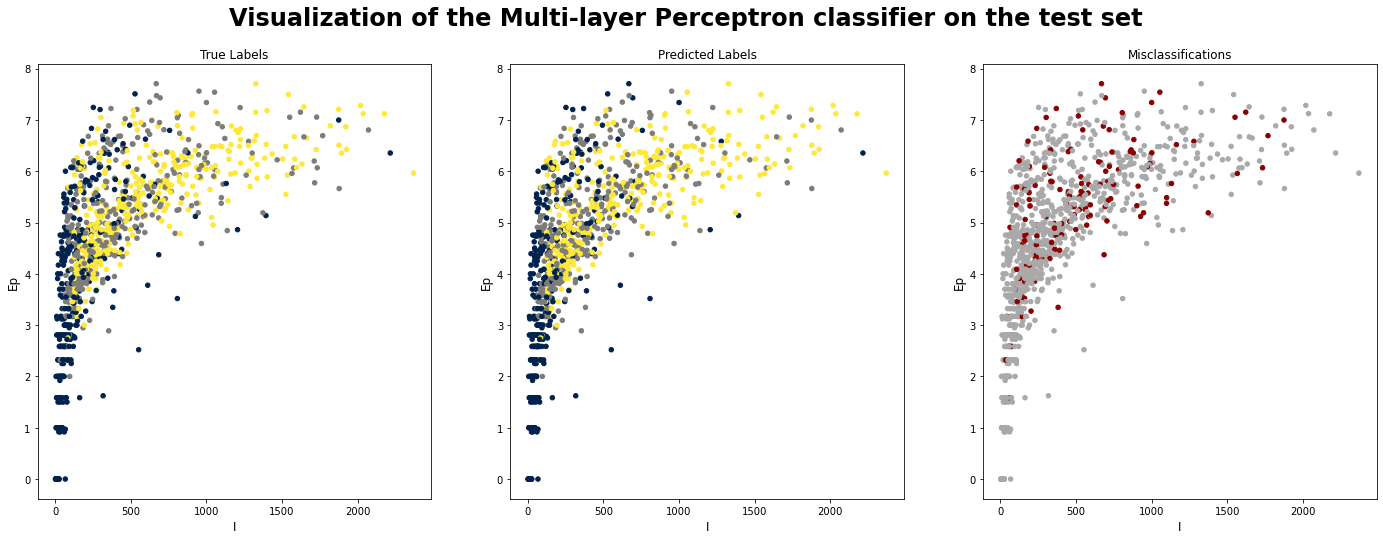

In [206]:
classification_visualizer(test_set, test_label, test_pred_mlp, 'Multi-layer Perceptron')

The misclassified points are very few: the fact that the prediction is really accurate confirms the power of this model.

##### Confusion Matrix of the classifier

In [207]:
# plot_c_matrix(test_set, test_label, test_pred_mlp, mlp, 'Multi-layer Perceptron')

##### Visualization of the decision boundary of the classifier

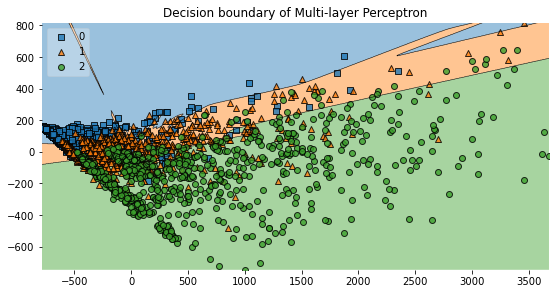

In [208]:
plot_decision_boundary(train_set, train_label, mlp, 'Multi-layer Perceptron')

Decision boundaries for this model are not so easy to interpret: they seem to be radial. It is not easy to see from this plot if they are accurate.

##### ROC curve of the classifier

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

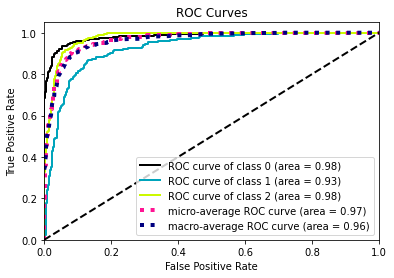

In [209]:
skplt.metrics.plot_roc(test_label, test_pred_proba_mlp)

#### Comments on MLP classifier
One of the most important advantages of Multi-layer Perceptron is the capability to learn non-linear models. However, it has also some disadvantages to take into consideration:
- different random weight initializations can lead to different validation accuracy
- it requires tuning a lot of hyperparameters: grid-search process can be very time-consuming
- it is sensitive to feature scaling: for this reason, a pre-processing phase is needed.

##### Comments on optimizers for MLP
We know from literature that, for relatively large datasets, *Adam* is very robust. It usually converges quickly and gives pretty good performance. *SGD* with momentum or nesterov’s momentum, on the other hand, can perform better if learning rate is correctly tuned.

### Decision Tree
A non-parametric supervised learning method used for classification and regression
The deeper the tree, the more complex the decision rules and the fitter the model.

scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now.

#### Import libraries

In [210]:
from sklearn import tree
from scipy.stats import randint

#### Pre-processing

Consider performing dimensionality reduction (PCA, ICA, or Feature selection) beforehand to give your tree a better chance of finding features that are discriminative.

Remember that the number of samples required to populate the tree doubles for each additional level the tree grows to. Use max_depth to control the size of the tree to prevent overfitting.

Use min_samples_split or min_samples_leaf to ensure that multiple samples inform every decision in the tree, by controlling which splits will be considered. A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data
For classification with few classes, min_samples_leaf=1 is often the best choice.


#### Grid search
Decision-tree learners can create over-complex trees that do not generalise the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.

In [211]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

In [212]:
dt_max_depth = [2,3,5,6,7,10,12, None]
dt_min_samples_split = randint(2, 51)
min_samples_leaf = randint(1, 51)
criterion = ["entropy", "gini"]
splitter = ["best", "random"]
max_features = [None, 2, 3, 4, 5]

dt_param_grid = {
    "max_depth": dt_max_depth,
    "min_samples_split": dt_min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "criterion": criterion,
    "splitter": splitter,
    "max_features": max_features
            }

In [213]:
#define the number of iters (random combination to try)
n_iter_search = 500

In [214]:
#define the number of jobs to run in parallel
n_jobs_search = -1

In [215]:
#define the grid search
dt_grid = RandomizedSearchCV(tree.DecisionTreeClassifier(), param_distributions=dt_param_grid, 
                            n_iter=n_iter_search,  
                            n_jobs=n_jobs_search,
                            scoring=make_scorer(accuracy_score))

In [216]:
dt_grid.fit(train_set, train_label)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': [None, 2, 3, 4, 5],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021B04CE61C0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021B052D2880>,
                                        'splitter': ['best', 'random']},
                   scoring=make_scorer(accuracy_score))

In [217]:
print(dt_grid.best_params_)

{'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 9, 'min_samples_split': 28, 'splitter': 'best'}


#### Training

In [218]:
dt = tree.DecisionTreeClassifier(**dt_grid.best_params_).fit(train_set, train_label)

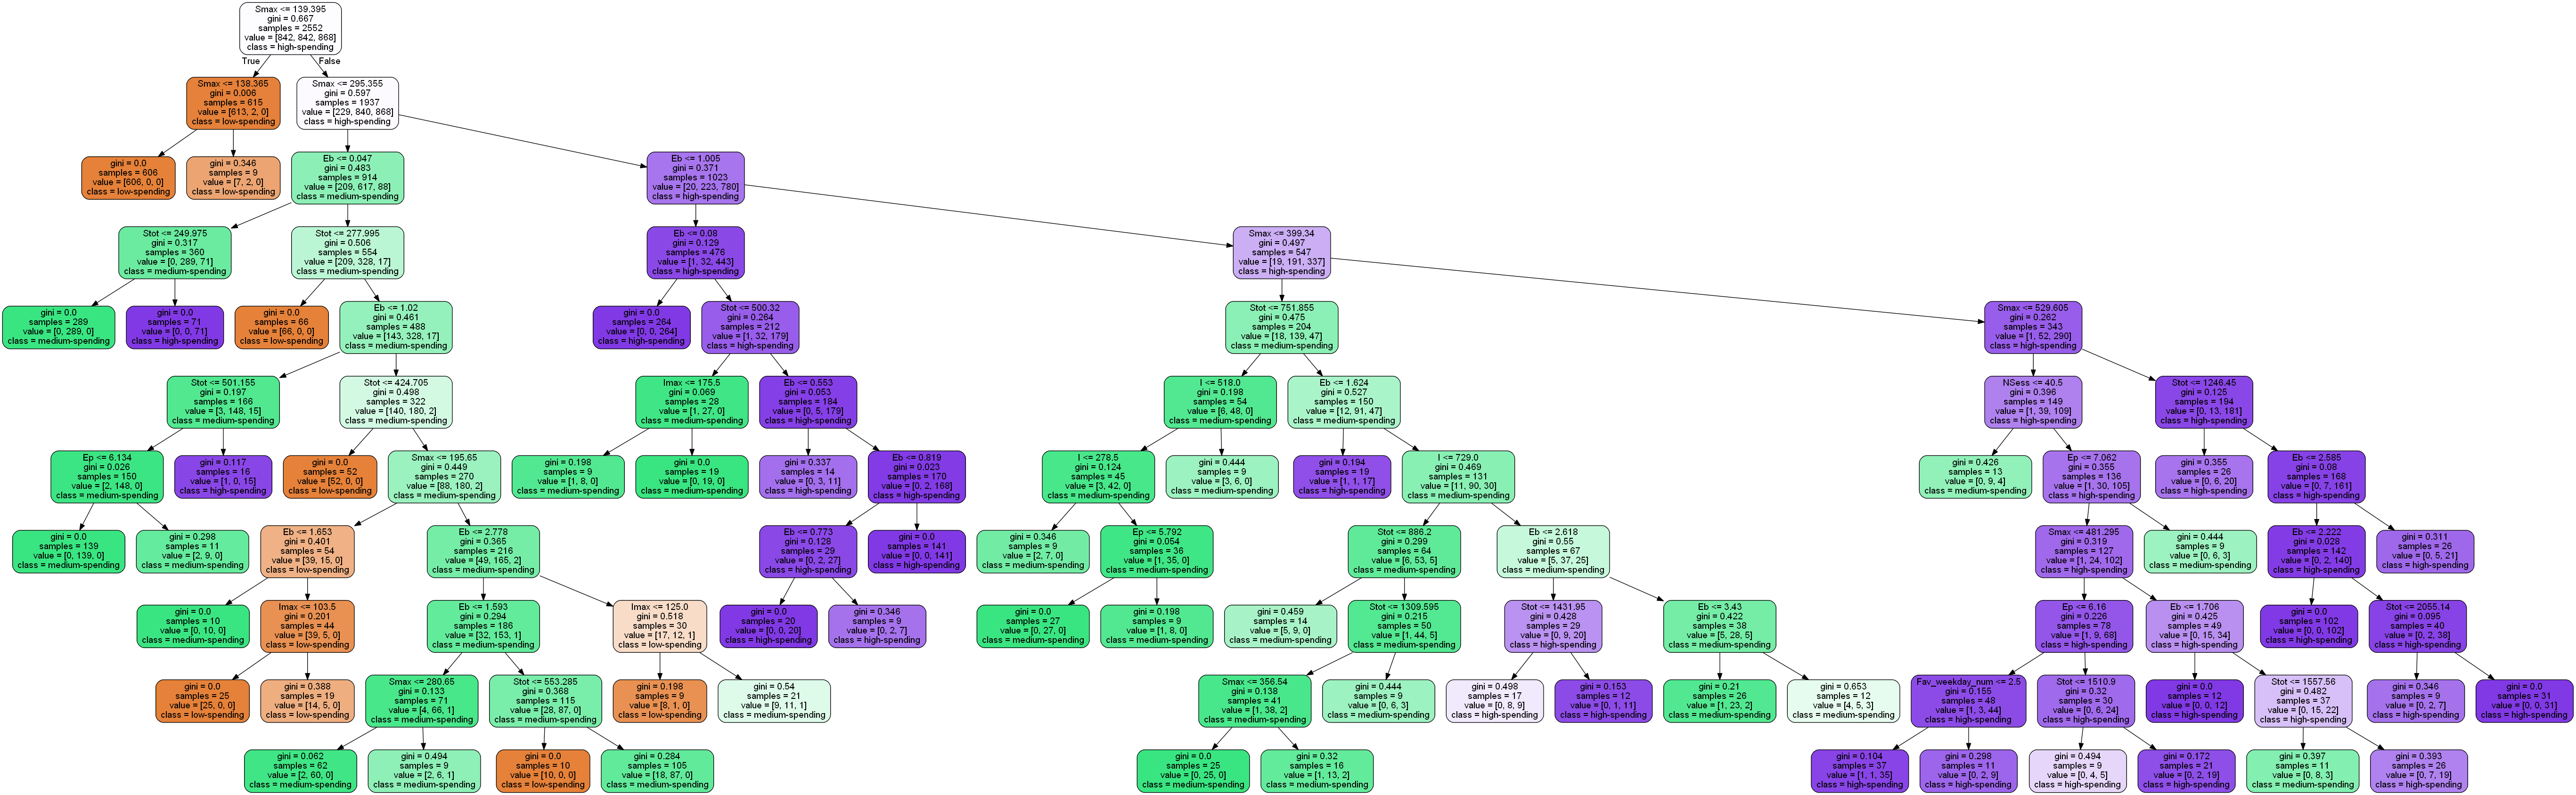

In [219]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image 
class_names=['low-spending', 'medium-spending', 'high-spending']
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=class_names,  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

#### Test

In [220]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

#### Evaluation

##### Discussing the possibility of overfitting

In [221]:
#evaulate the accuracy on the train set and the test set
#metrics also contains precision, recall, f1 and the support
from sklearn import metrics
print('Accuracy train set ', metrics.accuracy_score(train_label, train_pred_dt))
print('Accuracy test set ', metrics.accuracy_score(test_label, test_pred_dt))

Accuracy train set  0.9498432601880877
Accuracy test set  0.916819012797075


##### Model performance on the training set

In [222]:
report_scores(train_label,train_pred_dt)

                 precision    recall  f1-score   support

   low_spending       0.99      0.94      0.96       842
medium-spending       0.92      0.94      0.93       842
  high-spending       0.95      0.97      0.96       868

       accuracy                           0.95      2552
      macro avg       0.95      0.95      0.95      2552
   weighted avg       0.95      0.95      0.95      2552



##### Model performance on the test set

In [223]:
report_scores(test_label,test_pred_dt)

                 precision    recall  f1-score   support

   low_spending       0.99      0.93      0.96       361
medium-spending       0.87      0.88      0.88       361
  high-spending       0.90      0.94      0.92       372

       accuracy                           0.92      1094
      macro avg       0.92      0.92      0.92      1094
   weighted avg       0.92      0.92      0.92      1094



##### Visualization of the classifier results via scatterplots

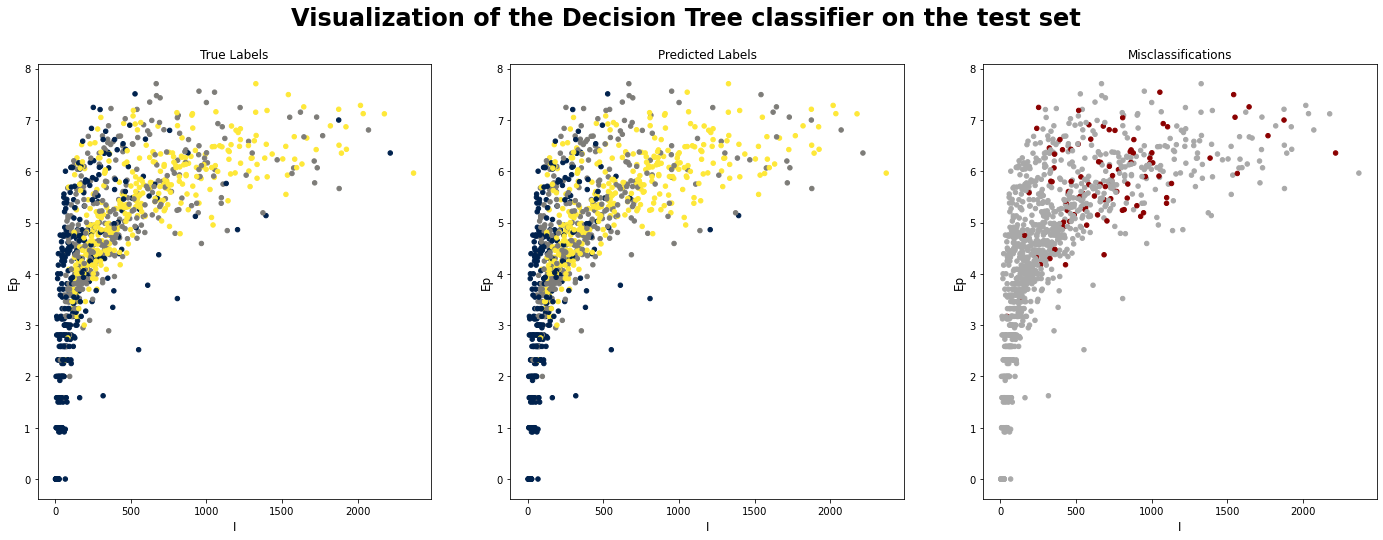

In [224]:
classification_visualizer(test_set, test_label, test_pred_dt, 'Decision Tree')

The accuracy of this model is optimal, also for the test set.The misclassified points are very few. This leads us to argue that the **Decision Tree is one of the best candidates to be the best model for our data**.

##### Confusion Matrix of the classifier

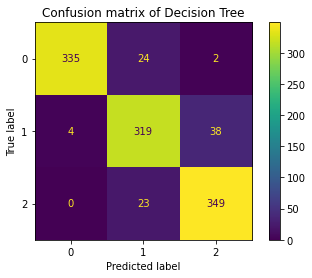

In [225]:
plot_c_matrix(test_set, test_label, test_pred_dt, dt, 'Decision Tree')

There are very few errors in class attribution for this model.

##### Visualization of the decision boundary of the classifier

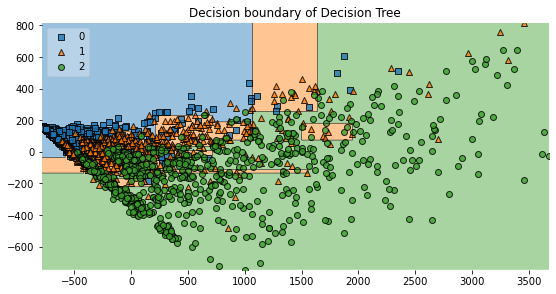

In [226]:
plot_decision_boundary(train_set, train_label, dt, 'Decision Tree')

The decision boundaries traced by this model for our data are geometric and so not-curvilinear: besides their shape, they seem to be quite precise and accurate.

##### ROC curve of the classifier

In [228]:
# probabilities
# test_pred_proba_dt = dt.predict_proba(test_set)

In [ ]:
# skplt.metrics.plot_roc(test_label, test_pred_proba_dt)

### Classification with Ensemble Methods
This approach is really powerful because it is based on learning multiple classification models and returning as a result a combination of their different prediction (i.e. best trade-off). In this way this method ensure that no bias towards some class exists. The final combination of all the models, having each single one biased towards a specific class, results in an average of all these biases: therefore the final model is unbiased and reliable.

The fundamental property that must be guaranteed for this methods in order to have a good performance is that **models must be  independent**: this means that there is to be no relation between different classifiers.

#### Import libraries

In [229]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

An ensemble classifier constructs a set of base classifiers from the training data and performs classification by taking a vote on the predictions made by each base classifier. We consider 3 types of ensemble classifiers in the example below: **bagging, boosting, and random forest.**

#### Computing accuracy for three ensemble classifiers 

In the example below, we fit 500 base classifiers to our dataset using each ensemble method. The base classifier corresponds to a decision tree with maximum depth equals to 10.

In [230]:
numBaseClassifiers = 500
maxdepth = 10
trainAcc = []
testAcc = []

X_train = train_set.values
Y_train = train_label
X_test = test_set.values
Y_test = test_label

clf = ensemble.RandomForestClassifier(n_estimators=numBaseClassifiers)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

clf = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

clf = ensemble.AdaBoostClassifier(DecisionTreeClassifier(max_depth=maxdepth),n_estimators=numBaseClassifiers)
clf.fit(X_train, Y_train)
Y_predTrain = clf.predict(X_train)
Y_predTest = clf.predict(X_test)
trainAcc.append(accuracy_score(Y_train, Y_predTrain))
testAcc.append(accuracy_score(Y_test, Y_predTest))

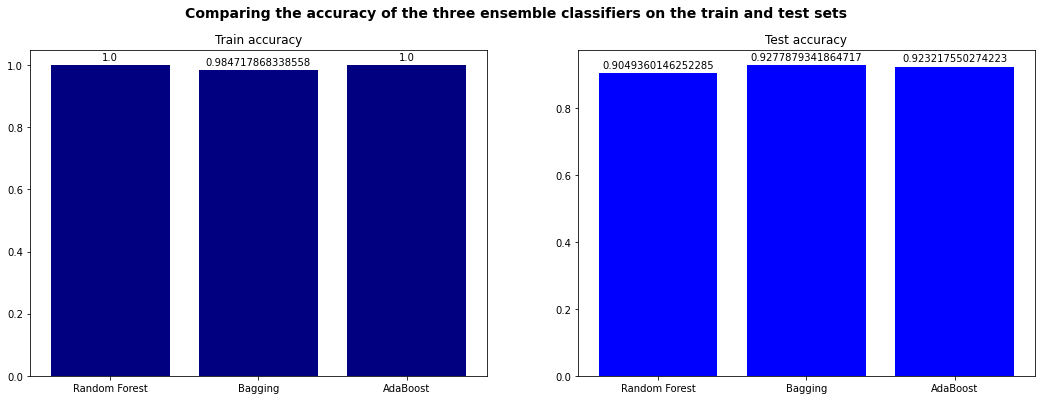

In [231]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

acc=[trainAcc, testAcc]
methods = ['Random Forest', 'Bagging', 'AdaBoost']
color = ['navy', 'blue', 'cyan']
title = ['Train accuracy', 'Test accuracy']
for i in range(2):
    autolabel(axs[i].bar([1.5,2.5,3.5], acc[i], color=color[i]), i)
    axs[i].set_xticks([1.5,2.5,3.5])
    axs[i].set_xticklabels(methods)
    axs[i].set_title(title[i])
    
plt.suptitle(('Comparing the accuracy of the three ensemble classifiers on the train and test sets'),
                 fontsize=14, fontweight='bold')
plt.show()

Source: [*Introduction to Data Mining (Second Edition)*](http://www.cse.msu.edu/~ptan/dmbook/tutorials/tutorial6/tutorial6.html), classification tutorial.

From the obtained results on the accuracy values we can see that all three models have good performance, both on training and on test data.

Now let's pick one to explore it deeply.


### Random Forest
Random Forest is a kind of Ensemble Method classifiers that works by manipulating input features.

This approach is based on Decision Tree classifiers: it basically consists in a forest of DTs, each one learned with a different subset of attributes. It combines the predictions made by multiple DTs and outputs the class that is the **mode** of the class's output by individual trees.

In this project we use the [Scikit Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). It fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is controlled with the *max_samples* parameter if *bootstrap* is True, otherwise the whole dataset is used to build each tree.

#### Guarantee a good performance
In case the number of attributes is too low, the different DTs in the forest may not be independento from each other: in fact, correlation between models depends on the number of sttributes that populates each tree.
This can be a problem for the resulting performance of algorithm based on ensemble method, like random forest itself. 

So if the model is learning too few features, the resulting performance of the classifier may not be good.

For this reason the *max_features* parameter is used to control this functioning and ensure a satisfying performance of the model. 



#### Grid search
To find the best set of parameters (because it strongly depends on data).

In [232]:
#to find the best set of parameter setting, we can run a grid search
#define the parameters' values you want to try
param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "max_features": ["auto", "sqrt", "log2", randint(1, len(train_set.iloc[0]) + 1)],
              "min_samples_split": randint(10, 51),
              "min_samples_leaf": randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', 'balanced_subsample', None]}
#define the number of iters
n_iter_search = 50
#define the model
clf = RandomForestClassifier(n_estimators=30) # The number of trees in the forest
#define the grid search
grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(train_set, train_label)

RandomizedSearchCV(estimator=RandomForestClassifier(n_estimators=30), n_iter=50,
                   n_jobs=10,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [2, 3, 5, 6, 7, 10, 12,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021B0273ACD0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021B052D2700>},
                   scoring=make_scorer(acc

Print the best set of hyperparameters for this dataset.

In [233]:
print('Best setting parameters\n', grid_search.cv_results_['params'][0])
print('\nMean of this setting\n', grid_search.cv_results_['mean_test_score'][0], 
      '\n\nStandard Deviation (std) of this setting\n', grid_search.cv_results_['std_test_score'][0])

Best setting parameters
 {'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 21, 'min_samples_split': 12}

Mean of this setting
 0.8597076090710256 

Standard Deviation (std) of this setting
 0.026343868902603405


#### Run the model: without class weights

In [234]:
rf = RandomForestClassifier(n_estimators=30,  # The number of trees in the forest
                             criterion='entropy',
                             max_features='log2', 
                             min_samples_split=40,
                             min_samples_leaf=14,
                             max_depth = 3,
                             bootstrap=False)
rf = rf.fit(train_set, train_label)

#prediction on the train test
train_pred_rf = rf.predict(train_set)

#prediction on the test test
test_pred_rf = rf.predict(test_set)

#### Probabilities

In [235]:
test_pred_proba_rf = rf.predict_proba(test_set)

In [236]:
test_pred_proba_rf # probability of belonging to class 0, 1 or 2

array([[0.05081971, 0.25069795, 0.69848234],
       [0.16677228, 0.43975062, 0.39347711],
       [0.90378517, 0.08518991, 0.01102492],
       ...,
       [0.37238633, 0.57515515, 0.05245851],
       [0.06267746, 0.33490073, 0.60242181],
       [0.38329061, 0.48795219, 0.1287572 ]])

#### Evaluation

##### Model performance on the training set

In [237]:
#compute the performance of the model
report_scores(train_label, train_pred_rf)

                 precision    recall  f1-score   support

   low_spending       0.98      0.74      0.85       842
medium-spending       0.72      0.67      0.69       842
  high-spending       0.74      0.96      0.83       868

       accuracy                           0.79      2552
      macro avg       0.81      0.79      0.79      2552
   weighted avg       0.81      0.79      0.79      2552



##### Model performance on the test set

In [238]:
#compute the performance of the model
report_scores(test_label, test_pred_rf)

                 precision    recall  f1-score   support

   low_spending       0.96      0.71      0.81       361
medium-spending       0.66      0.60      0.63       361
  high-spending       0.72      0.96      0.82       372

       accuracy                           0.76      1094
      macro avg       0.78      0.76      0.76      1094
   weighted avg       0.78      0.76      0.76      1094



The values obtained for precision and recall on all three classes are really good. Also the accuracy has a really good result.

This is probably another model to be candidate as the one of the best for our data.

##### Visualization of the classifier results via scatterplots

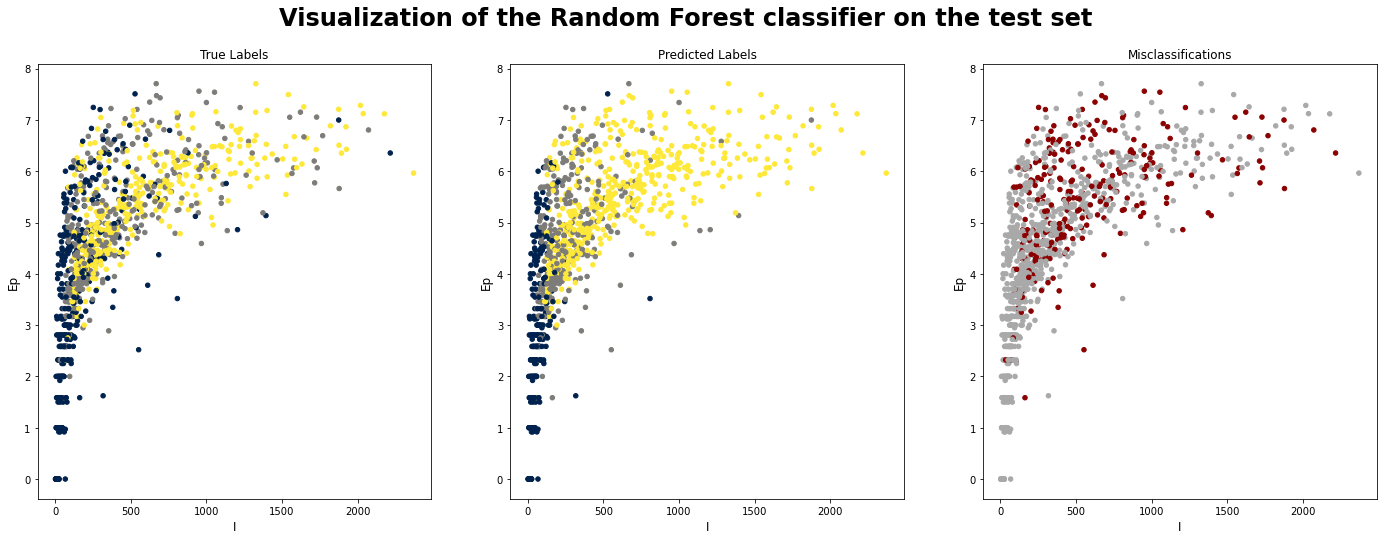

In [239]:
classification_visualizer(test_set, test_label, test_pred_rf, 'Random Forest')

Misclassified points are really few and the prediction on test labels is quite accurate.

##### Confusion Matrix of the classifier

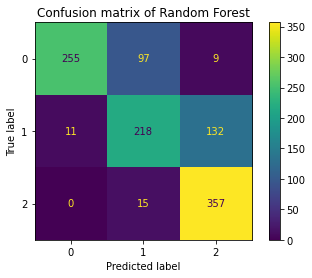

In [240]:
plot_c_matrix(test_set, test_label, test_pred_rf, rf, 'Random Forest')

In this case, the class that reports more errors is that of low spending, erroneously classified more often as medium spending.

##### Visualization of the decision boundary of the classifier

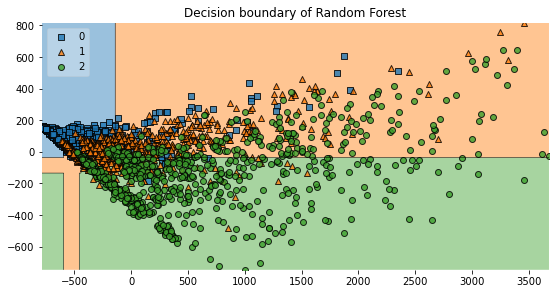

In [241]:
plot_decision_boundary(train_set, train_label, rf, 'Random Forest')

As the Decision Tree, also the Random Forest classifier has geometric boundaries. They also seem to be quite accurate in the space division.

##### ROC curve of the classifier

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

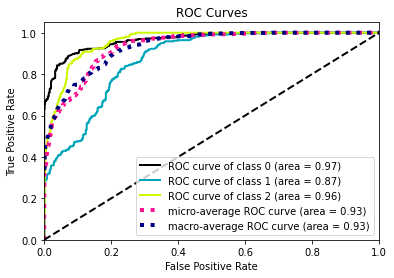

In [242]:
skplt.metrics.plot_roc(test_label, test_pred_proba_rf)

#### Random Forest final considerations 

We have seen that the Random Forest is a very powerful model: in general, we know from the literature that classifiers based on ensemble method often guarantee great performances.

##### Advantages
- It is one of the most accurate learning algorithms available. For many data sets, it produces a high accurate classifier.
- It runs efficiently on large databases: since running DTs is fast, this approach is convenient. Learning is not too costly.
- It can handle thousands of input variables without variable deletion.
- It gives estimates of what variables are important in the classification.
- It generates an internal unbiased estimate of the generalization error as the forest building progresses.

### Voting classifier

The idea behind the [Scikit VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) is to combine conceptually different machine learning classifiers and use a majority vote (hard vote) or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.

For this reason we considered this algorithm very interesting in the context of ensemble methods and also *new* (compared to the algorithms we have seen in class), and so we decided to include it in our analysis.

#### Run the model

In [243]:
from sklearn.svm import SVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
                        ('SVM', svm), 
                        ('Decision Tree', dt), 
                        ('GaussianNB', gnb),  
                        ('RandomForest', rf),
                        ('MLP', mlp)
                        ], voting='soft')

vc.fit(train_set.values, train_label)

VotingClassifier(estimators=[('SVM',
                              SVC(C=0.5, decision_function_shape='ovo',
                                  probability=True)),
                             ('Decision Tree',
                              DecisionTreeClassifier(max_depth=10,
                                                     min_samples_leaf=9,
                                                     min_samples_split=28)),
                             ('GaussianNB', GaussianNB()),
                             ('RandomForest',
                              RandomForestClassifier(bootstrap=False,
                                                     criterion='entropy',
                                                     max_depth=3,
                                                     max_features='log2',
                                                     min_samples_leaf=14,
                                                     min_samples_split=40,
                                   

In [244]:
#predict on the train set
train_pred_vc = vc.predict(train_set)
train_pred_vc

array([1, 0, 2, ..., 1, 0, 2])

In [245]:
#predict on the test set
test_pred_vc = vc.predict(test_set)
test_pred_vc

array([2, 1, 0, ..., 1, 2, 0])

In contrast to majority voting (hard voting), soft voting returns the class label as argmax of the sum of predicted probabilities.

Specific weights can be assigned to each classifier via the weights parameter. When weights are provided, the predicted class probabilities for each classifier are collected, multiplied by the classifier weight, and averaged. The final class label is then derived from the class label with the highest average probability.

##### Probabilities

In [246]:
test_pred_proba_vc = vc.predict_proba(test_set)
test_pred_proba_vc

array([[0.01055146, 0.19265561, 0.79679293],
       [0.08682566, 0.80353349, 0.10964086],
       [0.94546515, 0.05281459, 0.00172026],
       ...,
       [0.42538689, 0.56134221, 0.0132709 ],
       [0.04676454, 0.32074291, 0.63249256],
       [0.50014808, 0.45926054, 0.04059138]])

#### Evaluation

##### Model performance on the training set

In [247]:
report_scores(train_label,train_pred_vc)

                 precision    recall  f1-score   support

   low_spending       0.97      0.89      0.93       842
medium-spending       0.86      0.86      0.86       842
  high-spending       0.89      0.96      0.92       868

       accuracy                           0.90      2552
      macro avg       0.90      0.90      0.90      2552
   weighted avg       0.90      0.90      0.90      2552



##### Model performance on the test set

In [248]:
report_scores(test_label,test_pred_vc)

                 precision    recall  f1-score   support

   low_spending       0.97      0.86      0.91       361
medium-spending       0.79      0.79      0.79       361
  high-spending       0.83      0.92      0.87       372

       accuracy                           0.86      1094
      macro avg       0.86      0.86      0.86      1094
   weighted avg       0.86      0.86      0.86      1094



Also this model results to have good values on prediction performances, both on train and on tests set.

We confirm what was said above about the good effectiveness of ensemble classifiers.

##### Visualization of the classifier results via scatterplots

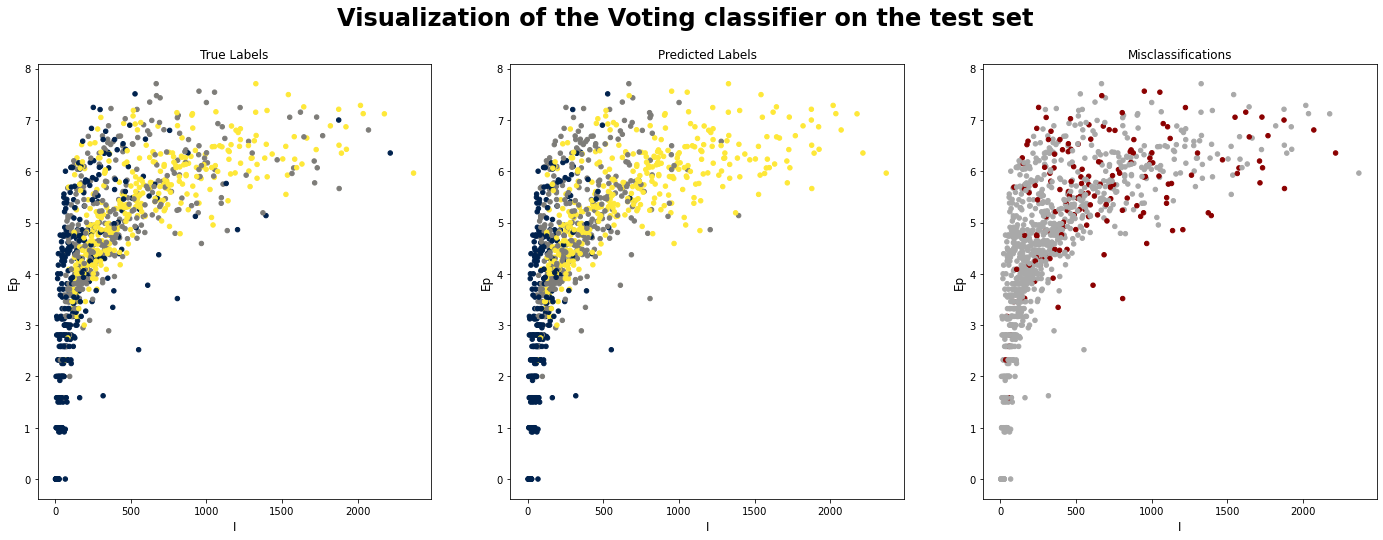

In [249]:
classification_visualizer(test_set, test_label, test_pred_vc, 'Voting')

##### Confusion Matrix of the classifier

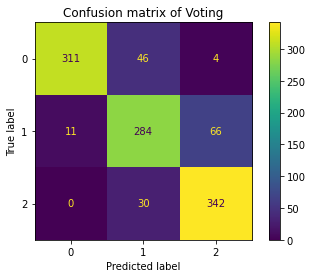

In [250]:
plot_c_matrix(test_set, test_label, test_pred_vc, vc, 'Voting')

Misclassified points as well as errors in the arribution of the class are very few.

##### Visualization of the decision boundary of the classifier

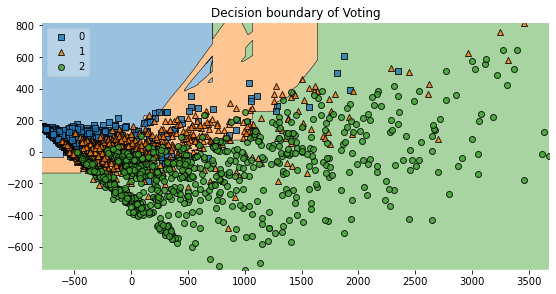

In [251]:
plot_decision_boundary(train_set, train_label, vc, 'Voting')

The fact that the decision boundaries for this model have both straight and curvilinear lines could result from the fact that it is a combination of other models. However, the hyperplanes seem to accurately divide the data into the three classes.

##### ROC curve of the classifier

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

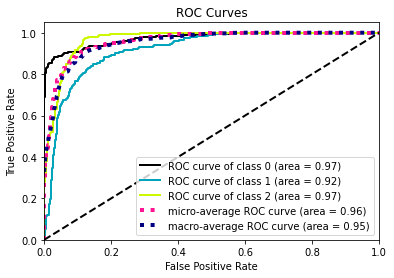

In [252]:
skplt.metrics.plot_roc(test_label, test_pred_proba_vc)

# Global models' evaluation


## Visualizing misclassifications
In order to recognize at a glance which classifiers are better or worse, we have chosen to report a scatter plot for each model, displaying the misclassified points.

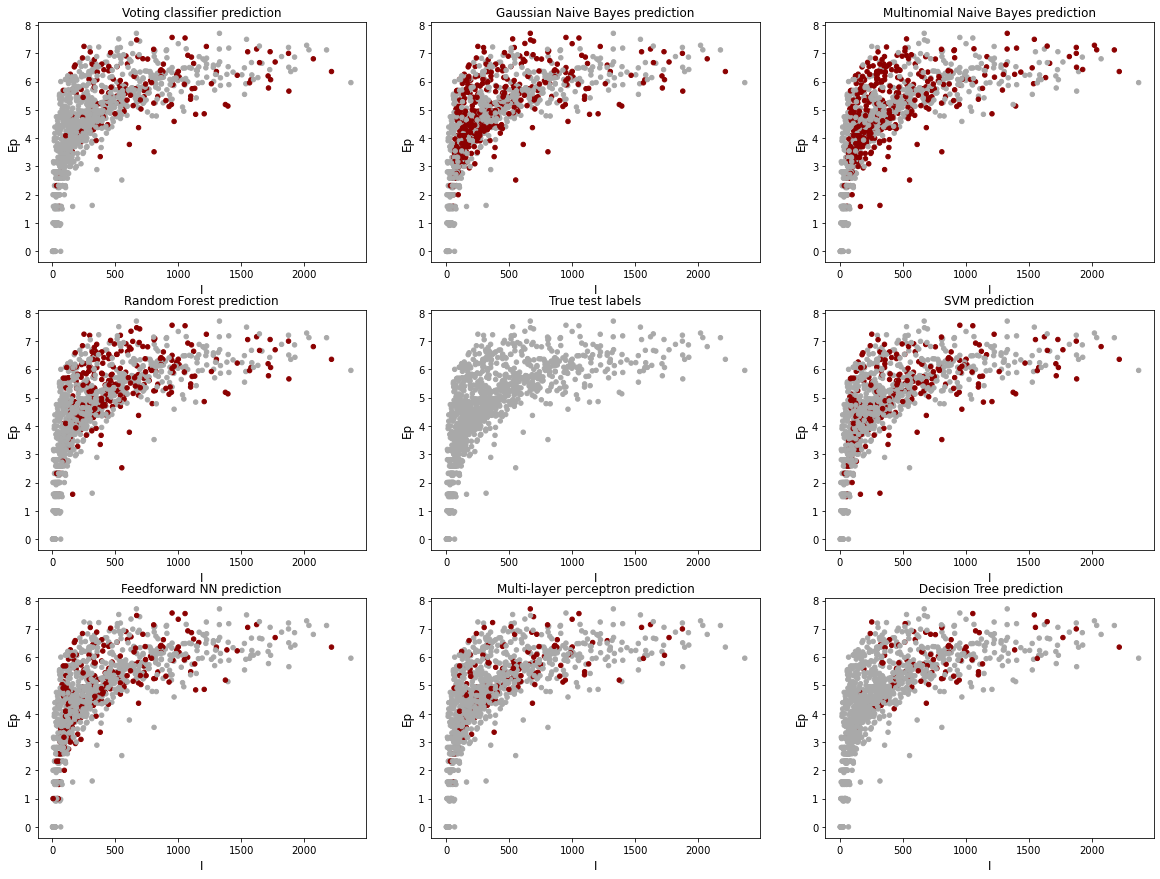

In [253]:
       
fig = plt.figure(figsize=(20,15))
fig_dims = (3, 3)
a, b = 'I', 'Ep'

titles=['Voting classifier prediction', 'Gaussian Naive Bayes prediction', 'Multinomial Naive Bayes prediction', 
       'Random Forest prediction', 'True test labels', 'SVM prediction', 'Feedforward NN prediction', 'Multi-layer perceptron prediction', ' Decision Tree prediction']
models=[test_pred_vc, test_pred_gnb, test_pred_mnb, test_pred_rf, test_label, test_pred_svm, test_pred_nn, test_pred_mlp, test_pred_dt]

w=0
for i in range(0,3):
    for j in range(0,3):
        plt.subplot2grid(fig_dims, (i,j))
        errors = spot_errors(test_label, models[w])
        plt.scatter(test_set[a], test_set[b], c=errors, s=20, cmap='cividis')
        plt.title(titles[w])
        plt.xlabel(a, fontdict={'fontsize': 'large'})
        plt.ylabel(b, fontdict={'fontsize': 'large'})
        w+=1

## Accuracy for each model
Another way to compare all the models is to see which one has the best accuracy on the predicted labels for the test set.

In [254]:
pred = [test_pred_knn, test_pred_radius, test_pred_gnb, test_pred_mnb, test_pred_svm, test_pred_nn, test_pred_mlp, test_pred_dt, test_pred_rf, test_pred_vc]
model = ['KNN', 'Radious-Neightbor', 'GaussianNB', 'MultinomialNB', 'SVM', 'NN', 'Multi-layer perceptron', 'Decision Tree', 'Random Forest', 'Voting']

for i in range(len(pred)):
    print('Accuracy of ',model[i],'\t', metrics.accuracy_score(test_label, pred[i]))


Accuracy of  KNN 	 0.8382084095063985
Accuracy of  Radious-Neightbor 	 0.7330895795246801
Accuracy of  GaussianNB 	 0.6060329067641682
Accuracy of  MultinomialNB 	 0.5950639853747715
Accuracy of  SVM 	 0.7568555758683729
Accuracy of  NN 	 0.783363802559415
Accuracy of  Multi-layer perceptron 	 0.8692870201096892
Accuracy of  Decision Tree 	 0.916819012797075
Accuracy of  Random Forest 	 0.7586837294332724
Accuracy of  Voting 	 0.856489945155393


As previously discovered, **the last four models confirms to be the best: (in order) Multi-layer perceptron, Random Forest, Voting, and (first place) Decision Tree.**

# Task 3 version 2: classification based on clustering results

#### Dataset import for clustering-based classification
N.B. High correlations have already been removed from this dataset

In [255]:
cs2 = pd.read_csv('cs_clusters.csv', index_col=0)

## Preprocessing
### Discretize the categorical variables
...

In [256]:
#discretize the variable relationship, sex, occupation, marital-status, native-country, race
variables = ['Country', 'Fav_weekday', 'Fav_month']
cs2 = discretize_data(cs2, variables)

In [257]:
#drop the categorical variables since we don't need them anymore 
cs2.drop(columns=['Country', 'Fav_weekday', 'Fav_month'], axis=1,inplace=True)

In [258]:
cs2.drop(columns=['C2', 'C3', 'C5', 'C8', 'DBS14'], axis=1,inplace=True)

In [259]:
#result
cs2

I   Iu  Imax        Ep        Eb     Stot    Smax        Savg  \
CustomerID                                                                     
13047.0     1296   89   301  6.251688  2.883182  2614.81  449.70  290.534444   
14688.0     2312  133   251  6.718327  4.047886  3394.39  402.50  178.652105   
17809.0      305   27   204  4.754888  1.576066   729.45  560.40  182.362500   
16098.0      435   24   112  4.305245  2.728077  1107.51  293.14  158.215714   
18074.0       52    8    52  3.000000  0.000000   185.30  185.30  185.300000   
...          ...  ...   ...       ...       ...      ...     ...         ...   
13436.0       69    8    69  3.000000  0.000000   113.54  113.54  113.540000   
15520.0      194   17   194  4.087463  0.000000   320.70  320.70  320.700000   
13298.0       24    1    24  0.000000  0.000000    90.00   90.00   90.000000   
14569.0       29    7    29  2.725481  0.000000    80.09   80.09   80.090000   
12713.0      499   36   499  5.169925  0.000000   722.85  722.85  722.850000   

            NSess  DBS15  Country_num  Fav_weekday_num  Fav_month_num  
CustomerID                                                             
13047.0       146     -1           32                0              0  
14688.0       264     -1           32                0              0  
17809.0        27     -1           32                0              3  
16098.0        54     -1           32                1              0  
18074.0         8      0           32                5              4  
...           ...    ...          ...              ...            ...  
13436.0         8      0           32                0              1  
15520.0        17      0           32                0              1  
13298.0         1      1           32                0              1  
14569.0         9      0           32                0              1  
12713.0        36      2           13                1             11  

[3646 rows x 13 columns]

### Create the label using DBSCAN clustering result
We have modeled the labels according to the cluster they belong to, merging together the high-spending cluster and the wholesalers cluster, in order to guarantee three classes as output.

#### Using the clusters results

In [260]:
cs2['label_num'] = 3
cs2['label'] = 'spending'

In [261]:
for i in cs2.index:
    if (cs2.DBS15[i] == -1) | (cs2.DBS15[i] == 2):
        cs2['label_num'][i] = 2 # alto spendenti
        cs2['label'][i] = 'high-spending'
    if cs2.DBS15[i] == 0:
        cs2['label_num'][i] = 1 # medio spendenti
        cs2['label'][i] = 'medium-spending'
    if cs2.DBS15[i] == 1:
        cs2['label_num'][i] = 0 # basso spendenti
        cs2['label'][i] = 'low-spending'

<ipython-input-261-5148c238eabf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs2['label_num'][i] = 2 # alto spendenti
<ipython-input-261-5148c238eabf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs2['label'][i] = 'high-spending'
<ipython-input-261-5148c238eabf>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs2['label_num'][i] = 1 # medio spendenti
<ipython-input-261-5148c238eabf>:7: SettingWithCopyWarning: 
A value is tryi

In [262]:
#drop the categorical variables  
cs2.drop(columns=['label', 'DBS15'], axis=1,inplace=True)

In [263]:
# to classify, we first need to split the dataset into train and test dataset.
# we can do so using train_test_split, in this case we select a stratified split

label = cs2.pop('label_num')
train_set, test_set, train_label, test_label = train_test_split(cs2, label, stratify=label, test_size=0.30)

## Models
We run all 10 classifiers for this new label.

In [264]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(train_set, train_label)
radius = RadiusNeighborsClassifier(**radius_grid.best_params_).fit(train_set, train_label)
gnb = GaussianNB().fit(train_set, train_label)
mnb = MultinomialNB(alpha=0).fit(train_set, train_label)
svm = SVC(kernel='rbf', C=0.5, gamma='scale', probability=True, decision_function_shape='ovo').fit(train_set, train_label)
mlp = MLPClassifier(random_state=1, max_iter=300, activation='tanh', alpha=0.0001).fit(X_train, train_label)
dt = tree.DecisionTreeClassifier(**dt_grid.best_params_).fit(train_set, train_label)
rf = RandomForestClassifier(n_estimators=30, criterion='gini', max_features='log2', min_samples_split=24, min_samples_leaf=42, max_depth = 10, bootstrap=False).fit(train_set, train_label)
vc = VotingClassifier(estimators=[('SVM', svm), ('MultinomialNB', mnb), ('GaussianNB', gnb), ('RandomForest', rf), ('MLP', mlp)], voting='soft').fit(train_set.values, train_label)

C:\Users\Diletta\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
C:\Users\Diletta\anaconda3\lib\site-packages\sklearn\naive_bayes.py:511: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


## Predictions on test set

In [265]:
test_pred_knn = knn.predict(test_set)
test_pred_radius = radius.predict(test_set)
test_pred_gnb = gnb.predict(test_set)
test_pred_mnb = mnb.predict(test_set)
test_pred_svm = svm.predict(test_set)
test_pred_mlp = mlp.predict(X_test)
test_pred_dt = dt.predict(test_set)
test_pred_rf = rf.predict(test_set)
test_pred_vc = vc.predict(test_set)

## Evaluations

#### On test

In [269]:
model = ['KNN', 'Radious-Neightbor', 'GaussianNB', 'MultinomialNB', 'SVM', 'Multi-layer perceptron', 'Decision Tree', 'Random Forest', 'Voting']
pred= [test_pred_knn, test_pred_radius, test_pred_gnb, test_pred_mnb, test_pred_svm, test_pred_mlp, test_pred_dt, test_pred_rf, test_pred_vc ]


for i in range(len(pred)):
    print('\n', model[i])
    report_scores(test_label, pred[i])


 KNN
                 precision    recall  f1-score   support

   low_spending       0.61      0.55      0.58        20
medium-spending       0.91      0.98      0.95       766
  high-spending       0.97      0.80      0.88       308

       accuracy                           0.92      1094
      macro avg       0.83      0.78      0.80      1094
   weighted avg       0.92      0.92      0.92      1094


 Radious-Neightbor
                 precision    recall  f1-score   support

   low_spending       0.00      0.00      0.00        20
medium-spending       0.70      1.00      0.82       766
  high-spending       1.00      0.00      0.01       308

       accuracy                           0.70      1094
      macro avg       0.57      0.33      0.28      1094
   weighted avg       0.77      0.70      0.58      1094


 GaussianNB
                 precision    recall  f1-score   support

   low_spending       1.00      1.00      1.00        20
medium-spending       0.94      0.91      

The first thing that is important to note is that **the three classes are unbalanced**, since they have different support:  In fact, the population of the three classes was not equally distributed, as already observed in the "DBSCAN evaluation" section. In that section, in fact, it is clearly visible that low-spending customers and wholesalers are little populated groups.

We believe that this unbalanced situation had a huge impact on the models results.

In fact, only three models over a total of ten performed well: Decision Tree, Random Forest and Voting (by the way, the more powerful ones). 

Surprisingly, also the Gaussian Naive Bayes, which is a very simple model, performed quite well.

### Confusion matrices, decision boundaries

<Figure size 1440x1080 with 0 Axes>

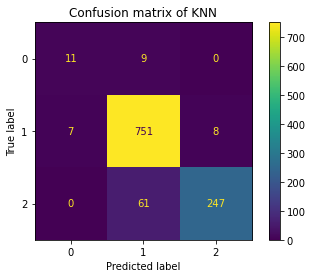

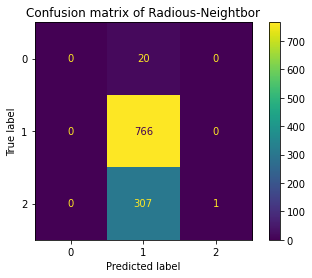

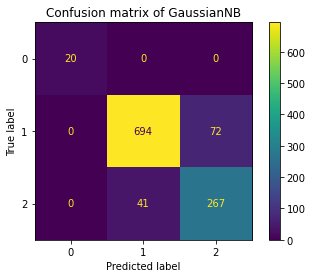

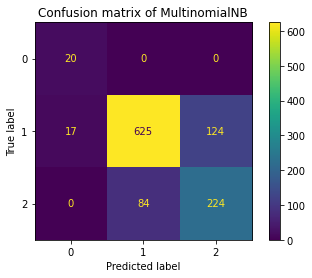

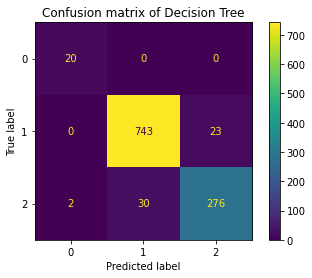

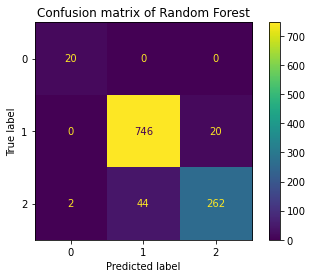

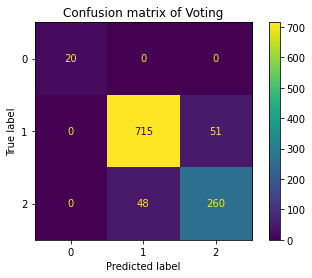

In [277]:
fig = plt.figure(figsize=(20,15))
fig_dims = (2, 4)

title = ['KNN', 'Radious-Neightbor', 'GaussianNB', 'MultinomialNB', 'Decision Tree', 'Random Forest', 'Voting']
pred= [test_pred_knn, test_pred_radius, test_pred_gnb, test_pred_mnb, test_pred_dt, test_pred_rf, test_pred_vc ]
# svm removed because cofusion matrix doesn't work for this model
model=[knn, radius, gnb, mnb, dt, rf, vc]

for i in range(len(pred)):
    plot_c_matrix(test_set, test_label, pred[i], model[i], title[i])

It's easy to see that the difference in support for each class has a huge impact: the colors of the matrix make this feature immediately visible.

Some powerful models like Decision Tree, Random Forest, Voting, but also the Gaussian Naive Bayes, performed pretty well.

However, to give a global evaluation, the errors of the other models are too high to be able to base the entire classification task on this label deriving from clustering.

Our choice to base it on the Savg attribute is therefore correct.

In [ ]:
fig = plt.figure(figsize=(20,15))
fig_dims = (2, 4)

title = ['KNN', 'GaussianNB', 'Multi-layer perceptron', 'Decision Tree', 'Random Forest', 'Voting Classifier']
pred= [test_pred_knn, test_pred_gnb, test_pred_mlp, test_pred_dt, test_pred_rf, test_pred_vc ]
# radius, multinomialNB and voring  removed because decision boundary plot doesn't work for this models
model=[knn, radius, gnb, mnb, mlp, dt, rf, vc]

for i in range(len(pred)):
    plot_decision_boundary(train_set, train_label, model[i], title[i])